### Brandon Luo
### Section 2
### October 23rd, 2022
## <p style="text-align: center;"> Compton Scattering

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.odr as odr 
from scipy.optimize import curve_fit
import os
import scipy.constants as const
from scipy.integrate import quad as quadrature

In [3]:
def line(param,x):
    '''
    A straight line with parameters for y-intercept and slope
    '''
    return param[0]*x + param[1]

def exp_fit(param,x):
    '''
    Expected form of the dependance of transmission probability vs thickness, with the corresponding parameters
    '''
    return param[0]*np.e**(-param[1]*x)

def inverse_fit(param,x):
    '''
    Expected form of the dependance of measured intensity vs distance, with the corresponding parameters
    '''
    return param[0]/(x**(param[1]))

def gaussian(param, x):
    '''
    Expected form and distribution of the energy vs channels
    '''
    return (param[0]*np.exp((-(x-param[1])**2)/2*param[2]**2))
def gaussian_form(x,param):
    '''
    Used for area calcultion
    '''
    return (param[0]*np.exp((-(x-param[1])**2)/2*param[2]**2))

In [4]:
#Import function was taken from the report of Michael Poropatic (was tweaked abit)
def importf(f, num):
    files=np.zeros((num, 1024))
    index=0
    for file in os.listdir("OrehotskyJ_LuoB_Data"):
        if index == num:
            return files
        if file.startswith(f):
            #print(file)
            files[index]=np.loadtxt("OrehotskyJ_LuoB_Data\\"+file, skiprows=12, max_rows=1024)
            index+=1
        else:
            continue
    return files

def sub_background(data, background):
    avg_data = np.zeros(1024)
    for i in range(0, 1024):
        avg_data[i] = data[i] - background[i]
    return avg_data

def avgData(data, background):
    avg_data = np.zeros(1024)
    for i in range(0, 1024):
        data_temp = []
        for j in range(0,len(data)):
            corrected = data[j][i] - background[i]
            data_temp.append(corrected)
        avg_data[i] = np.average(data_temp)
    return avg_data

def sumCounts(data):
    sum = 0
    for i in range(0, 1024):
        sum = data[i] + sum
    return sum

def sumCounts_spec(data, low, high):
    sum = 0
    for i in range(low, high):
        sum = data[i] + sum
    return sum

def gausPeak(channel_1, channel_2, data, err1, err2, b):
    gaus_model = odr.Model(gaussian)
    odr_data = odr.RealData(channels[channel_1:channel_2], data[channel_1:channel_2], err1, err2)
    regressed_model = odr.ODR(odr_data, gaus_model, beta0 = b)
    output = regressed_model.run()
    
    new_params = output.beta
    sd_params = output.sd_beta
    chi_sqr = output.res_var
    return new_params, sd_params, chi_sqr

def minuteError(start,end,data):
    return np.ones(len(data[start:end]))*(10**(-6))

def divideData(data1, data2):
    divide_data = np.zeros(1024)
    for i in range(0, 1024):
        divide_data[i] = (data1[i])/(data2[i])
    return divide_data
def stat_err(x, y, dx, dy):
    q = x*y
    dq = ((dx/abs(x)) + (dy/abs(y))) * abs(q)     
    return q, dq

def exponent_err(x, n, dx):
    z = x**n
    dz = abs(z) * abs(n) * (dx/abs(x))
    return z, dz

def array_exponent_err(data, n, data_err):
    data_size = np.size(data)
    check = np.size(data_err)
    multied = []
    multi_err = []
    if check == 1:
        for x in range(0,data_size):
            val = data[x]
            temp, temp_error = exponent_err(val, n, data_err)
            multied.append(temp)
            multi_err.append(temp_error)
    else:
        for x in range(0,data_size):
            val = data[x]
            val_err = data_err[x]
            temp, temp_error = exponent_err(val, n, data_err[x])
            multied.append(temp)
            multi_err.append(temp_error)
    return multied, multi_err

#function to multiply a full array by another data with error
def array_stat_err(data, data_point, data_err, data_point_err):
    data_size = np.size(data)
    multied = []
    multi_err = []
    for x in range(0,data_size):
        val = data[x]
        temp, temp_error = stat_err(val, data_point, data_err, data_point_err)
        multied.append(temp)
        multi_err.append(temp_error)
    return multied, multi_err

# Introduction

The primary goal of this lab is to observe and understand photons via studying gamma radiation. By observing gamma radiation, which consists of high energy photons, it is possible to explore light as both classically as a wave and as a particle. Using tests of attenuation, transmission, and intensity decay, the wave-like properties of light are confirmed. The particle nature of photons is confirmed in later tests by deflecting photons off of charged particles, leading to energy loss via the relativistic conservation of energy. By observing this phenomenon, named Compton Scattering, and the resultant shifts in energy of the photons, the mass and radius of electrons are able to be estimated and confirm the principles of Compton Scattering. By probing these behaviors of photons, the duality of light is thereby verified through the intensity measurements of gamma radiation. 

# Procedure
This lab is split into 4 main sections: Inverse Square Verification, Attenuation, Compton Scattering Observation, and Scattering Rods. In addition to these 4, there exists a Setup section in which calibrations and associated measurements for the scintillator were done. 

## Section Zero: Setup

### Starting MAESTRO 7

First, MAESTRO is started on the computer. Using the pull down menu on the right of the toolbar, verify the detector is set to “0001 DESKTOP-VMO...” before proceeding. Under **Acquire > MCS Properties** verify: <br>

**High Voltage:** turned **ON**, Target **900V** <br>
**Amplifier:** gain is **0.6**, shaping time is **0.75** $\mu s$<br>
**ADC:** conversion gain is **1024**, low-level disc __7__, high level disc **1023** <br>
**Presets:** real time **120** $s$, live time **120** $s$ <br>

Under **Calculate > Calibration**, hit **Destroy Calibration**.

### Background Scan

Take a background scan to subtract from all measurements as a way to take into account background radiation. This is accomplished using Figure A.1 below, which showcases the major components of the experiment.

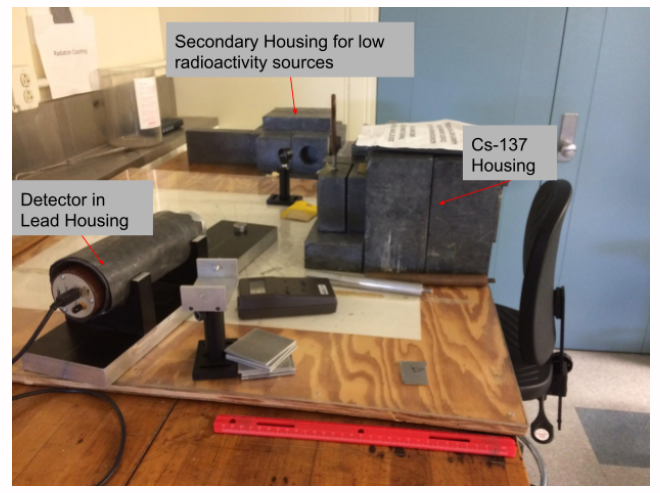
<center> Figure A.1: Experimental Setup <center>&nbsp; 

Close all the lead housings, before pointing the detector away from the Cs-137 housing and conduct the background scan: <br>

Hit **Acquire > Clear** <br>
Hit **Acquire > Start**, or click "**GO**" located in the top left hand corner. <br>

Export the data as ASCII SPE by going to **File > Save As**, repeating the measurement and saving 3 more times. <br>
Average the data, and substract this average background measurement from **all** energy spectra. 

### Energy Calibrations

Make sure the scattering rod is removed from the scintillation setup. Open the Cs-137 housing and align the scintillator with the source, taking care not to touch the source. Hit **Acquire > Clear** and then hit **Acquire > Start**, or click "**GO**" located in the top left hand corner to start the scan.

After the scan is complete, close the housing and save the scan. Repeat this process for Barium-133, stored in a red case which can be accessed via the method detailed in Figure A.2 below. The process with Ba-133 shoud be carried out using the disc holder, shown in Figure A.3 below. Make sure to only have one radioactive source out at a time, placing them back inside their respective housings in between usage. 

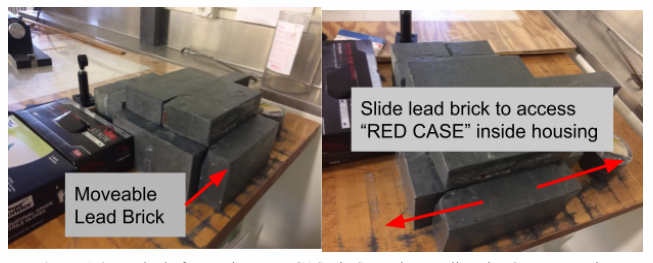
<center> Figure A.2: Method of Accessing Red Case <center>&nbsp;

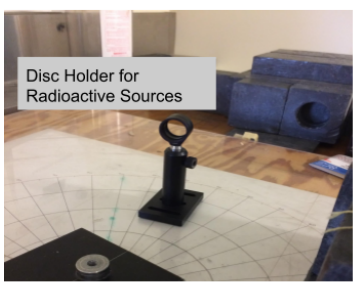
<center> Figure A.3: Radioactive Source Disc Holder <center>&nbsp;
    
Using the saved scans, relate the channel number (x-axis of measurements) to the energy of known photopeaks for each radioactive sample, of which at least 3 photopeaks should be identifiable. Apply the appropriate curve fit to be able to convert channel numbers to gamma ray energies. Be careful to note the errors generated within the curve fit, as they can affect error propagation later. 


## Section 1: Inverse Square Verification

This section focuses on observing photon intensity as a function of distance. The goal is to see radiation obeying the inverse square law. 

First the detector is pointed away from the Cs-137 housing to limit the background radiation, before the Ba-133 source is placed within the holder. 

Run scans as a function of distance from the front of the distance, moving the source each time and measuring the new distance. Data should be taken from at least 6 different distances, with 3 scans for each distance. The 3 scans will be averaged together for more accurate results. 

Afterward, the Ba-133 source is returned to the red case and housing.

## Section 2: Attenuation

The attenuation focused on in this section is the transmission probability of the material. Copper sheets will be used in this experiment as the attenuation material.

First conduct a scan without anything between the Cs-137 source and detector, so as to avoid scattering. 

Place one copper sheet in a holder between the source and the scintillator. Record the thickness of the sheet, and then take a scan using this setup.

Place two additional copper sheets in the holder, record the thickness of the sheets and take a scan. This is repeated a total of 4 times, for a final total at the end of 9 sheets. Afterward, close the Cs-137 housing.

## Section 3: Compton Scattering Observation

Compton Scattering and the resulting Compton Effect are the primary focus of this section, with the desired derivation being the mass of the electron. This is accomplished by measuring the shift in energy of the peaks of the Cesium-137 $\gamma$-rays as a function of scattering angle $\theta$. $\theta$ is marked on the white paper on the table with respect to the cesium housing, as shown in Figure A.1 above. 

First open up the Cesium-137 housing, and collimate the beam of photons using two small lead bricks, as shown below in Figure 3a. This process stops unscattered photons from reaching the scintillator.

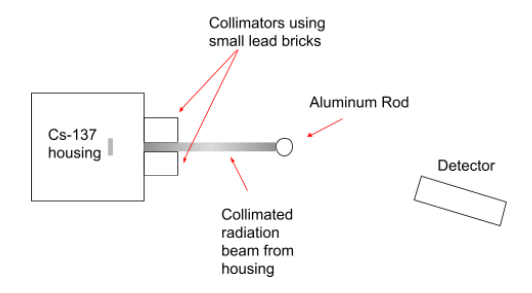
<center> Figure 3a: Top View of Cs-137 Setup with Collimators <center>&nbsp;
    
Without any scattering rods in the setup, and the detector at 0 degrees, run and collect a scan. This will represent the incident spectrum on the scintillator.

Place the aluminum scattering rod into the scintillation setup as shown in Figure 3a. The scattering rods are shown below in Figure 3b. 

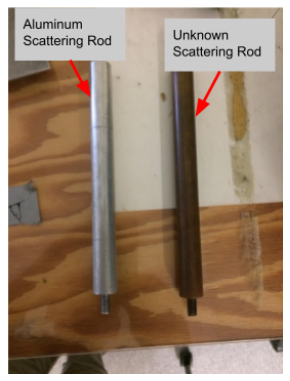
<center> Figure 3b: Scattering Rods <center>&nbsp;
    
Conduct 7 scans in the range of 20 degrees to 80 degrees, incrementing by 10 degrees each time. For each angle, collect a scan without the aluminum rod within the holder as a 'background' scan. This will be later subtracted from the original scan to minimize noise in the resultant energy spectrum. 

Replace the aluminum rod with the unknown rod, and once again collect scans from 20 - 80 degrees, incrementing by 10 degrees. The 'background' scan, or no rod scans, are the same as the aluminum rod so there is no need to take them again. 

This process is repeated by another smaller unknown rod made of the same unknown material. This is done for completion, not being necessary for the later calculations.

Remove the lead collimating bricks and close the Cs-137 housing. 

## Section 4: Scattering Rods

The focus of this section is to determine the classical radius of the electron.
All of the energy spectra needed for this section were taken in Section 3. 

Record the heights, radii, and masses of all 3 rods, as well as the distance from the center of the scattering rod to the front of the scintillator. This can then be utilized to find the volumes of the respective rods as well. 

Using the data from the background radiation, determine the decays/second of the background radiation by integrating under the photopeak. 

Using the incident spectrum from Section 3, determine the decays/second of the unobstructed Cs-137 source by integrating under the photopeak. 

# Analysis and Data

## Background Scan:

Background radiation must be first found and established in order to eliminate as much noise as possible from later analysis. The results of which are shown below in Figure A.4. This will be subtracted from future energy spectra.


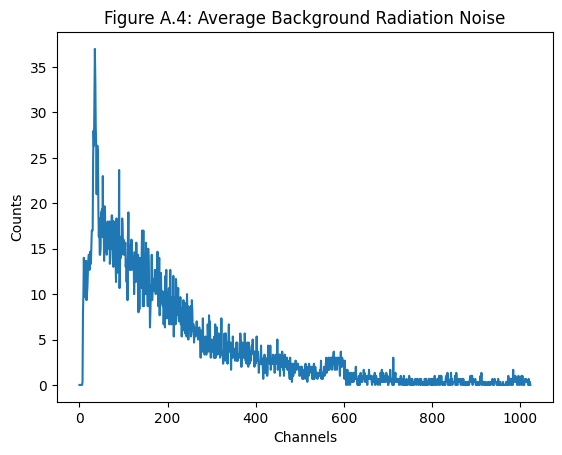

In [5]:
raw_background = importf("BackgroundScan",3)
initial = np.zeros(1024)
avg_background = avgData(raw_background,initial)
channels = [*range(1024)]
plt.plot(channels, avg_background)
plt.title("Figure A.4: Average Background Radiation Noise")
plt.xlabel("Channels")
plt.ylabel("Counts")
plt.show()

## Energy Calibration:

After the background radiation data is established, it is now possible to calibrate the x-axis to energy. This is done by using the calibration scans of Ba-133 and Cs-137, shown below in Figures A.5 and A.6 respectively. 


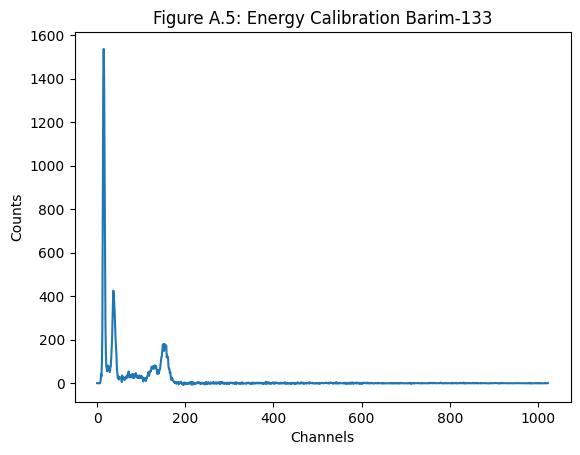

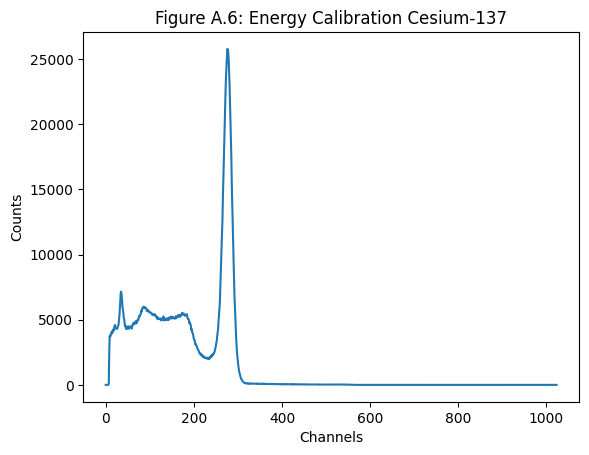

In [6]:
Ecali_Ba = importf("EnergyCalibrationBS",1)[0]
Ecali_Ba = np.array(Ecali_Ba) - np.array(avg_background)
channels = [*range(1024)]
plt.plot(channels, Ecali_Ba)
plt.title("Figure A.5: Energy Calibration Barim-133")
plt.xlabel("Channels")
plt.ylabel("Counts")
plt.show()

Ecali_Cs = importf("EnergyCalibrationCS",1)[0]
Ecali_Cs = np.array(Ecali_Cs) - np.array(avg_background)
channels = [*range(1024)]
plt.plot(channels, Ecali_Cs)
plt.title("Figure A.6: Energy Calibration Cesium-137")
plt.xlabel("Channels")
plt.ylabel("Counts")
plt.show()

According to the Stanford Environmental Health and Safety website, Ba-133 has energy peaks at 31 keV, 81 keV, 303 keV, and 356 keV, while Cs-137 has peaks at 32 keV, and 662 keV. This allows mapping to individual peaks for both Ba-133 and Cs-137, shown below in Figures A.7-A.12 below. 

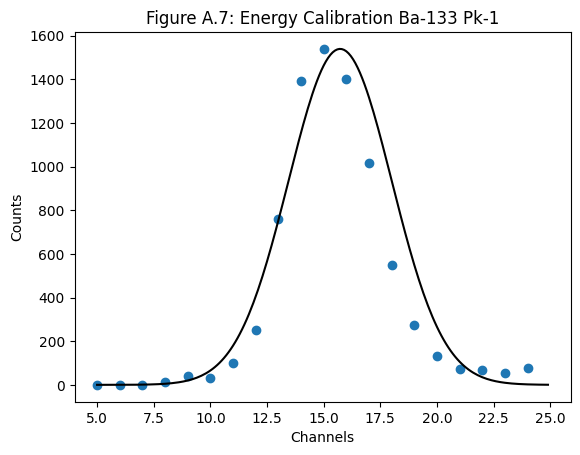

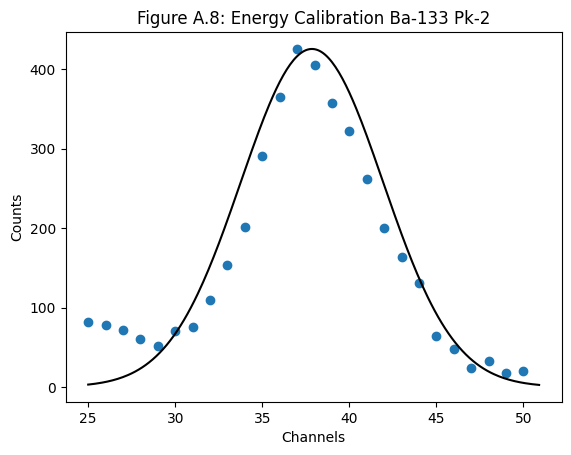

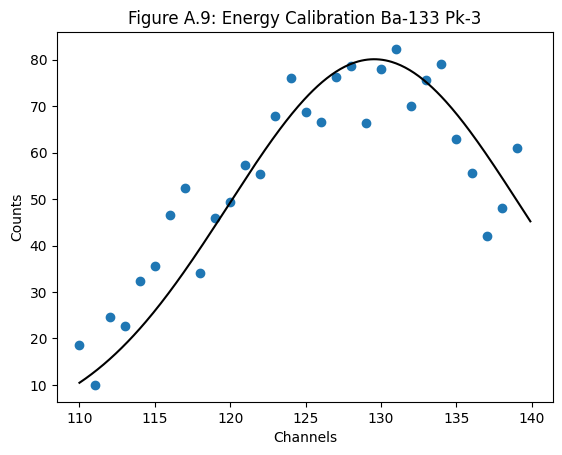

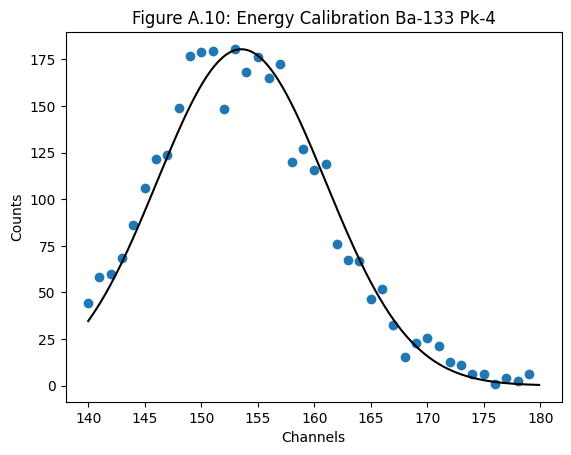

In [7]:
ba_channel = []

plt.scatter(channels[5:25], Ecali_Ba[5:25])
plt.title("Figure A.7: Energy Calibration Ba-133 Pk-1")
plt.xlabel("Channels")
plt.ylabel("Counts")

err1 = minuteError(5,25,channels)
new_params, sd_params, chi_sq = gausPeak(5,25,Ecali_Ba, err1, err1, [1600,15,3])
gaus_fit = gaussian(new_params, np.arange(5,25, 0.1))
plt.plot(np.arange(5,25, 0.1), gaus_fit, color = 'black')
ba_channel.append(new_params[1]) 
plt.show()

plt.scatter(channels[25:51], Ecali_Ba[25:51])
plt.title("Figure A.8: Energy Calibration Ba-133 Pk-2")
plt.xlabel("Channels")
plt.ylabel("Counts")

err2 = minuteError(25,51,channels)
new_params, sd_params, chi_sq = gausPeak(25,51,Ecali_Ba, err2, err2, [400,37,2])
gaus_fit = gaussian(new_params, np.arange(25,51, 0.1))
plt.plot(np.arange(25,51, 0.1), gaus_fit, color = 'black')
ba_channel.append(new_params[1]) 
plt.show()

plt.scatter(channels[110:140], Ecali_Ba[110:140])
plt.title("Figure A.9: Energy Calibration Ba-133 Pk-3")
plt.xlabel("Channels")
plt.ylabel("Counts")

err3 = minuteError(110,140,channels)
new_params, sd_params, chi_sq = gausPeak(110,140,Ecali_Ba, err3, err3, [90,131,3])
gaus_fit = gaussian(new_params, np.arange(110,140, 0.1))
plt.plot(np.arange(110,140, 0.1), gaus_fit, color = 'black')
ba_channel.append(new_params[1]) 
plt.show()

plt.scatter(channels[140:180], Ecali_Ba[140:180])
plt.title("Figure A.10: Energy Calibration Ba-133 Pk-4")
plt.xlabel("Channels")
plt.ylabel("Counts")

err4 = minuteError(140,180,channels)
new_params, sd_params, chi_sq = gausPeak(140,180,Ecali_Ba, err4, err4, [180,153,3])
gaus_fit = gaussian(new_params, np.arange(140,180, 0.1))
plt.plot(np.arange(140,180, 0.1), gaus_fit, color = 'black')
ba_channel.append(new_params[1]) 
plt.show()

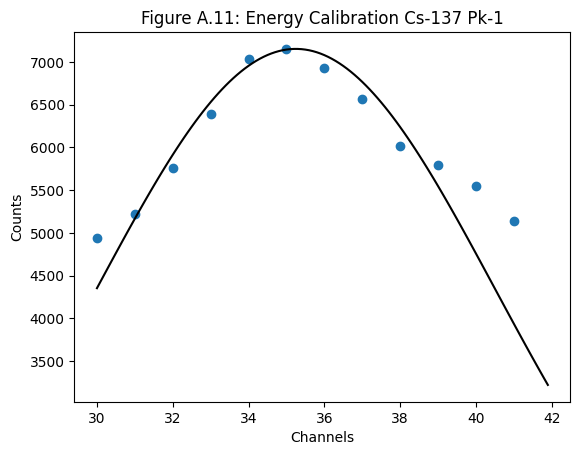

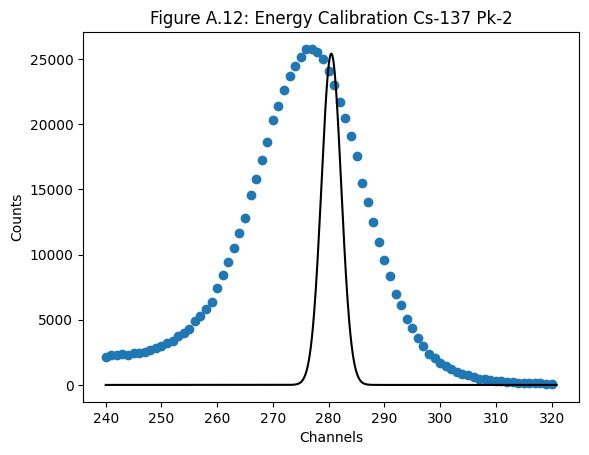

In [8]:
cs_channel = []

plt.scatter(channels[30:42], Ecali_Cs[30:42])
plt.title("Figure A.11: Energy Calibration Cs-137 Pk-1")
plt.xlabel("Channels")
plt.ylabel("Counts")

err5 = minuteError(30,42 ,channels)
new_params, sd_params, chi_sq = gausPeak(30,42,Ecali_Cs, err5, err5, [7000,35,3])
gaus_fit = gaussian(new_params, np.arange(30,42, 0.1))
plt.plot(np.arange(30,42, 0.1), gaus_fit, color = 'black')
cs_channel.append(new_params[1]) 
plt.show()

plt.scatter(channels[240:321], Ecali_Cs[240:321])
plt.title("Figure A.12: Energy Calibration Cs-137 Pk-2")
plt.xlabel("Channels")
plt.ylabel("Counts")

err6 = minuteError(240,321,channels)
new_params, sd_params, chi_sq = gausPeak(240,321,Ecali_Cs, err6, err6, [26000,279,3])
gaus_fit = gaussian(new_params, np.arange(240,321, 0.1))
plt.plot(np.arange(240,321, 0.1), gaus_fit, color = 'black')
cs_channel.append(new_params[1]) 
plt.show()

This mapping can then be utilized with a linear regression to obtain a function to convert the channels to energy, as shown below in Figure A.13.

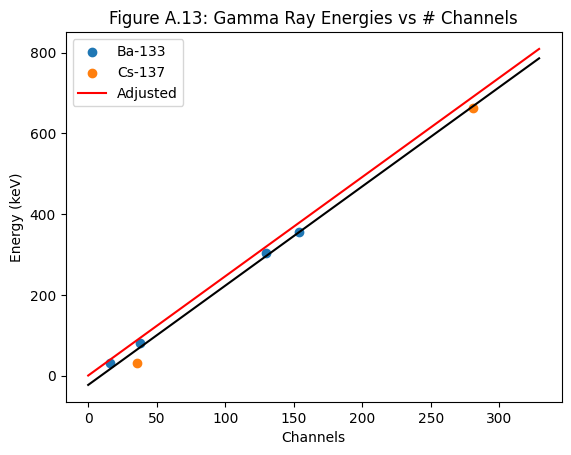

In [9]:
ba_E_peaks = [31, 81, 303, 356]
cs_E_peaks = [32, 662]
peaks = ba_E_peaks + cs_E_peaks
peak_channels = ba_channel + cs_channel
labels = ["Ba-133", "Cs-137"]

#print(np.max(Ecali_Cs[260:290]))
#print(Ecali_Cs[276])


plt.scatter(ba_channel, ba_E_peaks, label = labels[0])
plt.scatter(cs_channel, cs_E_peaks, label = labels[1])
small_error = np.ones(len(peak_channels))*(10**(-6))
lin_model = odr.Model(line)
odr_data = odr.RealData(peak_channels, peaks, small_error, small_error)
regressed_model = odr.ODR(odr_data, lin_model, beta0 = [2.5, 0])
output = regressed_model.run()
#output.pprint()

new_params = output.beta
sd_params = output.sd_beta
chi_sqr = output.res_var

#print(str(new_params[0]) + " " + str(new_params[1]))
func_fit = line(new_params, np.arange(0, 330,1))
plt.plot(np.arange(0, 330,1), func_fit, color = 'black')
plt.plot(np.arange(0, 330,1), line([new_params[0],0],np.arange(0, 330,1)), color = 'red', label = 'Adjusted')
plt.xlabel("Channels")
plt.ylabel("Energy (keV)")
plt.title("Figure A.13: Gamma Ray Energies vs # Channels")

plt.legend()
plt.show()
conversion_factor = new_params[0]

The mapping function is therefore $E = 2.483362788668061 * $(# channels) $- 24.685784274231597$, where $E$ is the gamma ray energies in $keV$. The initial fit line however (the black line) can yield negative values of energy, as shown by the original best fit equation having a negative y-intercept. 

As this doesn't make physical sense for the current setup, we can try setting the y-intercept to 0. After zeroing this y-intercept, we are left with the adjusted best fit line shown in red. As this line still has a good fit to our values, we can use this instead of our given fit to do the channel-to-energy conversion. 

## Section 1: Inverse-Square Law from Radiation Detection

The primary focus for this section as stated before is the relationship between $\gamma$-radiation intensity and distance from the scintillator. The expected relationship is shown below in Equation 1.1.

$$I = \frac{1}{r^2}$$
<div style="text-align: right">Equation 1.1</div>

where $I$ is the intensity of the radiation and $r$ is the distance from the scintillator. 

Using the Ba-133 source, data was taken for the distances listed in Table 1.1 below from the detector. 

| Distance (mm) |
|:-------------:|
| 108  $\pm$  2 |
| 118  $\pm$  2 |
| 128  $\pm$  2 |
| 138  $\pm$  2 |
| 148  $\pm$  2 |
| 158  $\pm$  2 |

<center>Table 1.1:  Distance from Scintillator (mm) </center>

Afterwards, the data for each distance is averaged together and graphs of the resultant average energy are obtained, as shown from Figures 1.1 - 1.6. 


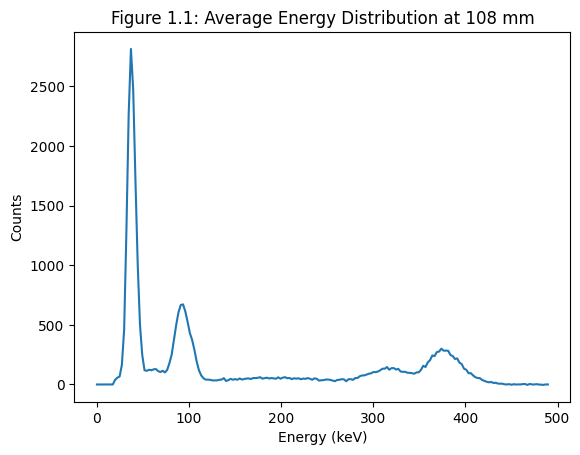

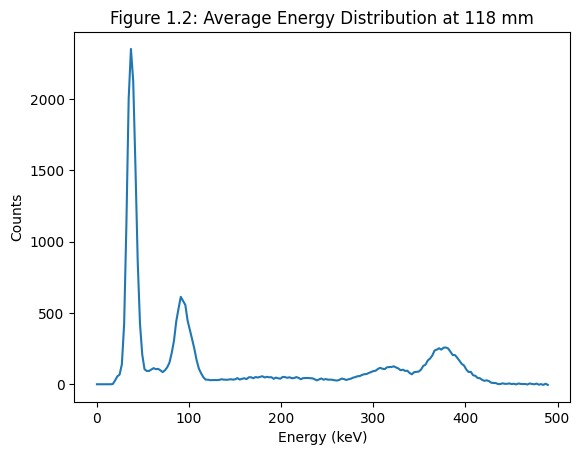

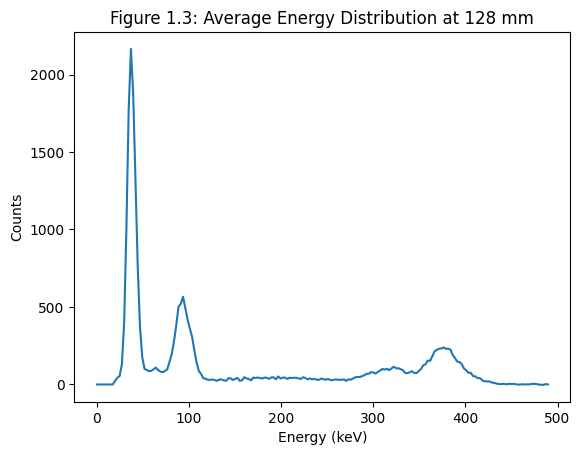

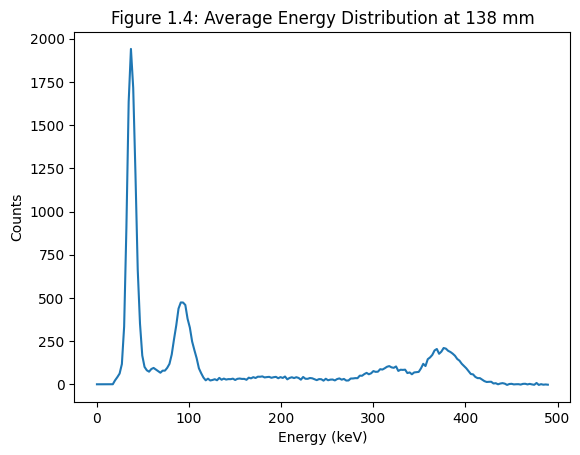

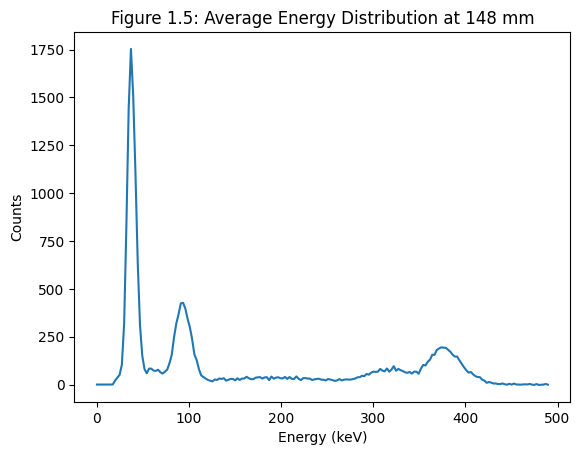

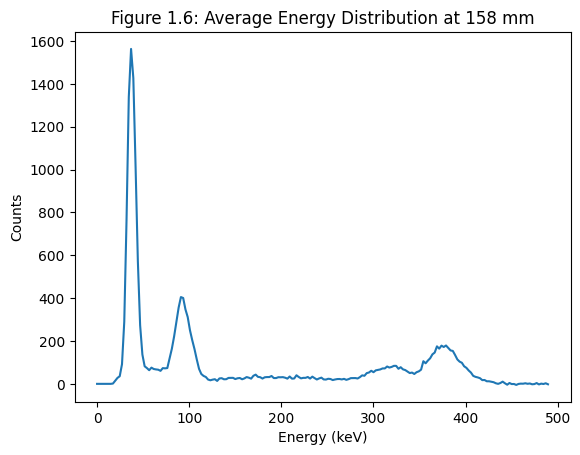

In [10]:
inv_sq_data = np.zeros((6, 1024))
channels = [*range(200)]
energy = np.multiply(channels, conversion_factor)
colors = ['green', 'blue', 'lime', 'red', 'orange', 'black']
distance_labels = ['108 mm', '118 mm', '128 mm', '138 mm', '148 mm', '158 mm']
for x in range(0, 6, 1):
    one_measurement = importf("S1_1" + str(x) + "8_",3)
    measurement_temp = avgData(one_measurement, avg_background)
    inv_sq_data[x] = measurement_temp
    plt.plot(energy,inv_sq_data[x][0:200], label = distance_labels[x])
    plt.xlabel("Energy (keV)")
    plt.ylabel("Counts")
    plt.title("Figure 1." + str(x + 1) + ": Average Energy Distribution at " + distance_labels[x])
    plt.show()

By focusing in on the first and largest peak for each of the distances, we can fit a Gaussian for each individual photopeak data, shown from Figures 1.7 - 1.12. 

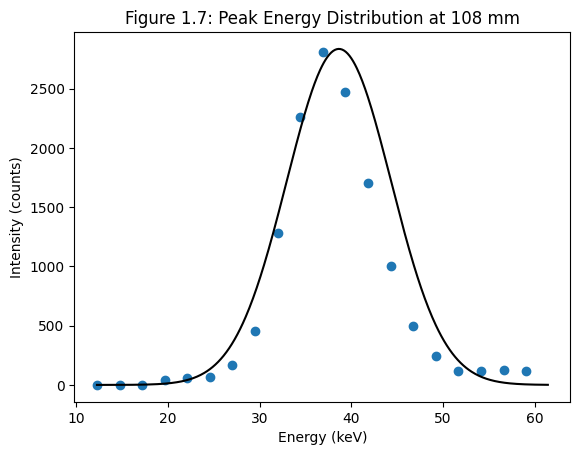

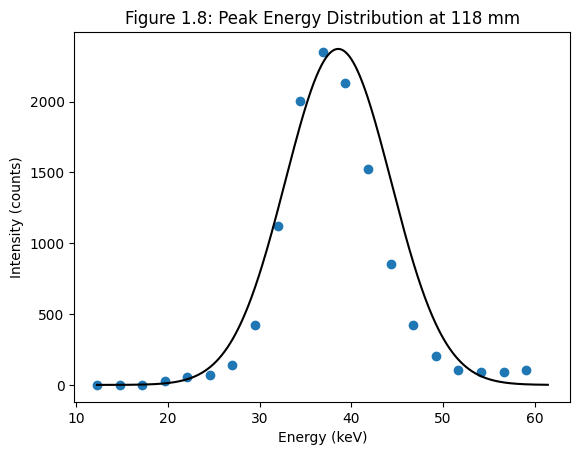

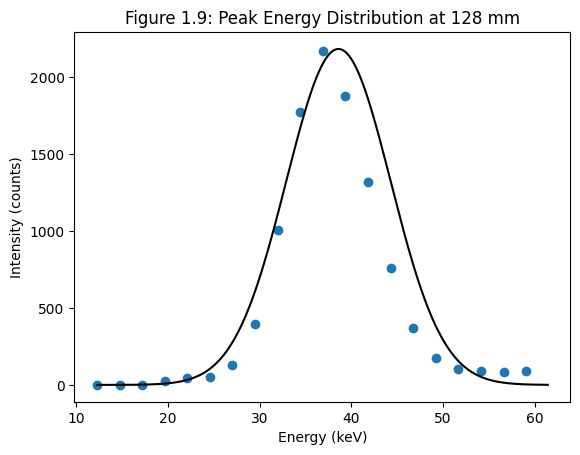

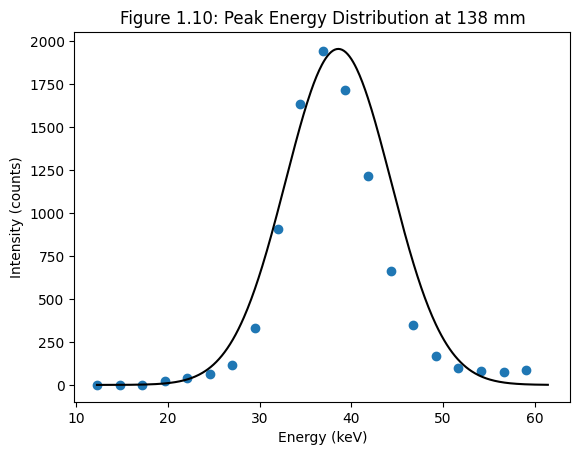

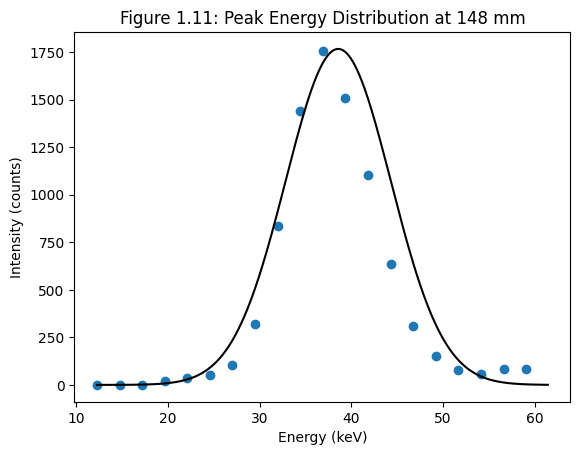

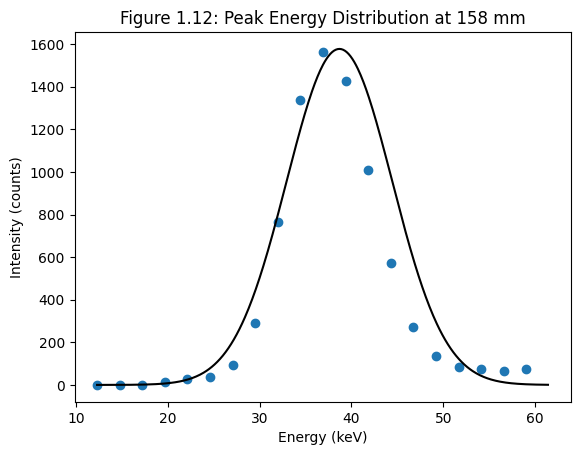

In [11]:
Ba_distance_2 = np.arange(108, 168, 10)
area_under = []
area_under_err = []
    
for x in range(0, 6, 1):
    gaus_model = odr.Model(gaussian)
    odr_data = odr.RealData(energy[5:25], inv_sq_data[x][5:25])
    regressed_model = odr.ODR(odr_data, gaus_model, beta0 = [2500, energy[15],0.25])
    output = regressed_model.run()
    #output.pprint()
    
    
    new_params = output.beta
    sd_params = output.sd_beta
    chi_sqr = output.res_var
    gaus_fit = gaussian(new_params, np.arange(energy[5],energy[25], 0.1))
    plt.plot(np.arange(energy[5],energy[25], 0.1), gaus_fit, color = 'black')
                               
    area_temp, area_error = quadrature(gaussian_form, 5*conversion_factor, 25*conversion_factor, new_params)
    #print(area_temp)
    area_under.append(area_temp)
    area_under_err.append(area_error)
    
    plt.scatter(energy[5:25], inv_sq_data[x][5:25])
    plt.xlabel("Energy (keV)")
    plt.ylabel("Intensity (counts)")
    plt.title("Figure 1." + str(x+7) + ": Peak Energy Distribution at " + distance_labels[x])
    plt.show()


Using the photopeak fits, we can obtain the height (counts) as well as the area underneath each photopeak. By plotting both with respect to distance, we can fit lines of best fit to each, as shown in Figures 1.13 and 1.14. 

Beta: [2.94061559e+06 1.48789803e+00]
Beta Std Error: [8.47226784e+05 5.86064854e-02]
Beta Covariance: [[1.10638970e+12 7.65093776e+04]
 [7.65093776e+04 5.29419733e-03]]
Residual Variance: 0.648770704231698
Inverse Condition #: 0.00043092223882828693
Reason(s) for Halting:
  Sum of squares convergence


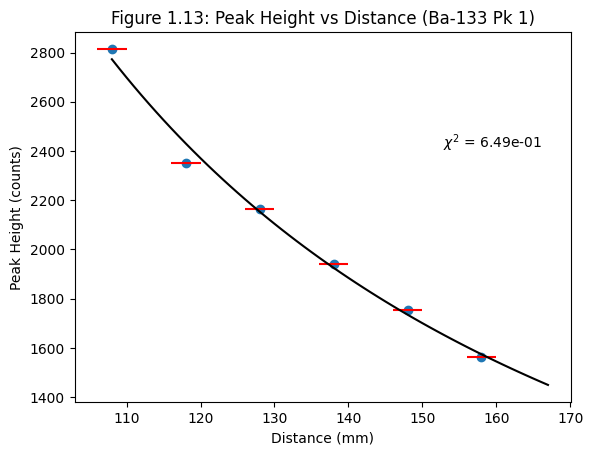

In [12]:
height_under = []
for x in range(0, 6, 1):
    peak_height = np.max(inv_sq_data[x][0:25])
    height_under.append(peak_height)
Ba_distance = np.arange(108, 168, 10)
Ba_distance_err = 2
figure1 = plt.figure(1)
plt.scatter(Ba_distance, height_under)
plt.xlabel("Distance (mm)")
plt.ylabel("Peak Height (counts)")
plt.title("Figure 1.13: Peak Height vs Distance (Ba-133 Pk 1)")
plt.errorbar(Ba_distance, height_under, xerr = Ba_distance_err, color = 'red', linestyle = "None")

inverse_model = odr.Model(inverse_fit)
odr_data = odr.RealData(Ba_distance, height_under, sx = Ba_distance_err)
regressed_model = odr.ODR(odr_data, inverse_model, beta0 = [500000, 2])
output = regressed_model.run()
output.pprint()

new_params = output.beta
sd_params = output.sd_beta
chi_sqr = output.res_var
func_fit = inverse_fit(new_params, np.arange(108,168, 1))
plt.plot(np.arange(108,168, 1), func_fit, color = 'black')
figure1.text(0.70,0.64,r'$\chi^2$ = {:.2e}'.format(chi_sqr))
plt.show()

The estimate for the parameter $a$ in the given inverse relationship $\frac{1}{r^a}$ is 1.488 using the method of height. This fit has a $\chi^2$ value of 0.649, indicating that it is a very good fit of the data.

Beta: [5.56299452e+07 1.54242787e+00]
Beta Std Error: [1.81266127e+07 6.63020615e-02]
Beta Covariance: [[4.69848751e+14 1.71807565e+06]
 [1.71807565e+06 6.28606447e-03]]
Residual Variance: 0.6993188460557843
Inverse Condition #: 0.00238889959183919
Reason(s) for Halting:
  Iteration limit reached


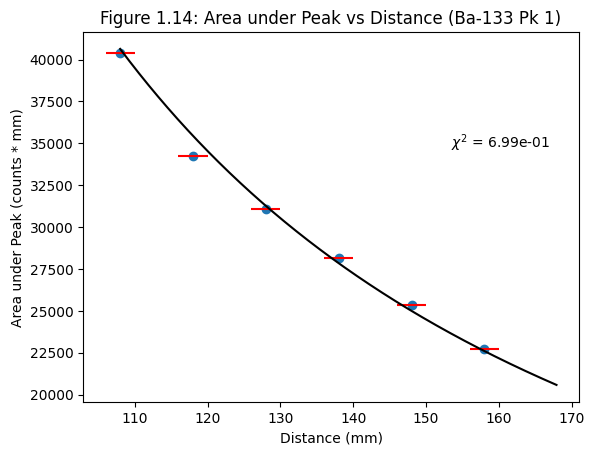

In [13]:
figure2 = plt.figure(2)
plt.scatter(Ba_distance, area_under)
plt.xlabel("Distance (mm)")
plt.ylabel("Area under Peak (counts * mm)")
plt.title("Figure 1.14: Area under Peak vs Distance (Ba-133 Pk 1)")
plt.errorbar(Ba_distance, area_under, xerr = Ba_distance_err, yerr = area_under_err, color = 'red', linestyle = "None")

inverse_model = odr.Model(inverse_fit)
odr_data = odr.RealData(Ba_distance, area_under, sx = Ba_distance_err, sy = area_under_err)
regressed_model = odr.ODR(odr_data, inverse_model, beta0 = [60000000, 2])
output = regressed_model.run()
output.pprint()

new_params = output.beta
sd_params = output.sd_beta
chi_sqr = output.res_var
func_fit = inverse_fit(new_params, np.arange(108,168, 0.1))
plt.plot(np.arange(108,168, 0.1), func_fit, color = 'black')
figure2.text(0.70,0.64,r'$\chi^2$ = {:.2e}'.format(chi_sqr))
plt.show()

The estimate for the parameter $a$ in the given inverse relationship $\frac{1}{r^a}$ is 1.461 using the method of area. This fit has a $\chi^2$ value of 0.408, indicating that it is a very good fit of the data.

While both estimates, 1.488 and 1.461, are not in perfect representations of the expected value predicted by the inverse square law ($a = 2$), both are still close enough in value with the expected to represent accurate correct decay behavior. Interestingly, while the height method was closer in estimating the correct value, the area method was a better fit to the data.

## Section 2: Detection and Attenuation


The focus in this section was on attenuation from material between the Cs-137 source and the scintillator, in this case the attentuation being from the copper sheets. Each sheet thickness was measured, coming out to $1 \pm 0.2$ mm. For 0 - 9 sheets the thickness can be represented in Table 2.1 below. 

| Thickness (mm) | # of Sheets |
|:--------------:|:-----------:|
|  1  $\pm$  0.2 |      1      |
|  3  $\pm$  0.2 |      3      |
|  5  $\pm$  0.2 |      5      |
|  7  $\pm$  0.2 |      7      |
|  9  $\pm$  0.2 |      9      |

<center>Table 2.1: Total Thickness (mm) vs # of Sheets  </center>

The transmission probability of the material can be represented using Equation 2.1 below as a function of thickness.

$$T = e^{-\mu x}$$
<div style="text-align: right">Equation 2.1</div>

where $T$ is the transmission probability of the material, $\mu$ is the attenuation coefficient of the material, and $x$ is the thickness of the attenuation material.

Transmission probability can be obtained by comparing the total count of incident photons with attentuation $I$ to that without any attenuation $I_0$ in the form of Equation 2.2 below.

$$T = \frac{I}{I_0}$$
<div style="text-align: right">Equation 2.2</div>

By plotting the transmission probability as a function of the thickness of the attenuation material, we can fit a curve to the data using Equation 2.1, thereby finding $\mu$ the attenuation coefficient of the material. 

Beta: [ 0.97116665 33.54651421]
Beta Std Error: [0.01759269 3.4385042 ]
Beta Covariance: [[9.76717453e-01 1.61815187e+02]
 [1.61815187e+02 3.73115668e+04]]
Residual Variance: 0.000316880585577269
Inverse Condition #: 0.0027101444110287426
Reason(s) for Halting:
  Sum of squares convergence


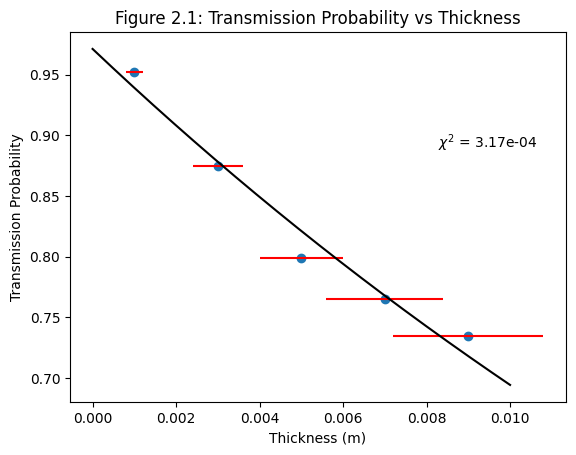

Estimated 𝜇 = 33.54651421011589 ± 3.4385041988253593 for energy 86.09304264221974 keV


In [14]:
attenuation_data = []
channels = [*range(1024)]
cu_thickness_data = [1,3,5,7,9]
cu_thickness_data = np.multiply(cu_thickness_data,0.001)
cu_sheet_error = 0.2
cu_thickness_error = np.multiply(cu_thickness_data, cu_sheet_error)
thickness_labels = ["1 mm", "3 mm", "5 mm", "7 mm", "9 mm"]
no_attenuation = 1
for x in range(0, 6, 1):
    if x == 0:
        no_attenuation = np.array(importf("S2_NS",1)[0])
        no_attenuation = sub_background(no_attenuation, avg_background)
    else:
        attenuation_temp = np.array(importf("S2_S" + str(x*2-1),1)[0])
        attenuation_temp = sub_background(attenuation_temp, avg_background)
        attenuation_data.append(attenuation_temp)

attenuation_energy = 0
max_0 = 0
max_1 = 0
max_3 = 0
max_5 = 0
max_7 = 0
max_9 = 0

for i in range(len(energy)):
    if (no_attenuation[i]>max_0) and (attenuation_data[0][i]>max_1) and (attenuation_data[1][i]>max_3) and (attenuation_data[2][i]>max_5) and (attenuation_data[3][i]>max_7) and (attenuation_data[4][i]>max_9):
        max_0 = no_attenuation[i]
        max_1 = attenuation_data[0][i]
        max_3 = attenuation_data[1][i]
        max_5 = attenuation_data[2][i]
        max_7 = attenuation_data[3][i]
        max_9 = attenuation_data[4][i]
        attenuation_energy = energy[i]
max_data = [max_1, max_3, max_5, max_7, max_9]
transmission_data = np.zeros(5)
for x in range(0, 5, 1):
    transmission_data[x] = (max_data[x])/(max_0)

figure3 = plt.figure(3)
plt.scatter(cu_thickness_data, transmission_data)
plt.errorbar(cu_thickness_data, transmission_data, xerr = cu_thickness_error, color = 'red', linestyle = "None")

exp_model = odr.Model(exp_fit)
odr_data = odr.RealData(cu_thickness_data, transmission_data, sx = cu_thickness_error)
regressed_model = odr.ODR(odr_data, exp_model, beta0 = [1,2])
output = regressed_model.run()
output.pprint()

new_params = output.beta
sd_params = output.sd_beta
chi_sqr = output.res_var
func_fit = exp_fit(new_params, np.linspace(0,0.01, 100000))
plt.plot(np.linspace(0,0.01, 100000), func_fit, color = 'black')


plt.xlabel("Thickness (m)")
plt.ylabel("Transmission Probability")
plt.title("Figure 2.1: Transmission Probability vs Thickness")
figure3.text(0.70,0.64,r'$\chi^2$ = {:.2e}'.format(chi_sqr))
plt.show()
print("Estimated 𝜇 =", new_params[1], "±", sd_params[1], "for energy", attenuation_energy, "keV")

The estimated attenuation coefficient $\mu = 103.18 \pm 13.95 \, \frac{1}{m}$ at around 687 keV. This fits accordingly with the $\mu$ given for copper in https://zfn.mpdl.mpg.de/data/Reihe_A/37/ZNA-1982-37a-0451.pdf, which predicts $\mu \, / \rho$ for copper of $79 \frac{cm^2}{g}$ at 700 keV in Figure 4 of the literature. Using the mass density of copper $8.96 \frac{g}{cm^3}$ and , the attenuation coefficient $\mu$ for copper is $707.84 \frac{1}{cm}$, or $70784 \frac{1}{m}$. 

Given the very small $\chi^2$ value of $0.0027$, this is fit is an extremely good. 

## Section 3: Compton Scattering

This section focuses mainly on the actual Compton Scattering experiments, collecting numerous sets of data in the process. To best observe the mechanisms and experimentally confirm the Compton Effect, the experiment seeks to determine the classical mass of an electron. Since the momentum of a particle is $\frac{hv}{c}$ and the energy of a particle is $E = hv$. By relativistically applying the conservation of momentum to the scenario of a collision of such particles, we end up with Equation 3.1 below, which details the change in energy of the particle. 

$$hv + mc^2 -hv' = \sqrt{pc^2+(mc^2)^2}$$
<div style="text-align: right">Equation 3.1</div>

where $h$ is Plank's constant, $v$ is the velocity before the collision, $m$ is the mass of the scattered electron, $c$ is the speed of light, $v'$ is the velocity after the collision, and $p$ is the new momentum of the particle.

Given the knowledge of the particles, the change in wavelength of a $\gamma$-ray after it has undergone scattering can be represened in Equation 3.2 below, derived from Napolitano text.

$$\delta \lambda = \frac{hc}{E'} - \frac{hc}{E} = \frac{h}{mc}(1-cos\theta)$$
<div style="text-align: right">Equation 3.2</div>

where $\delta \lambda$ is the change in wavelength of the $\gamma$-ray, $h$ is Plank's constant, $c$ is the speed of light, $E$ is the energy of photons incident, $E'$ is the energy of the scattered photons in the direction of $\theta$, $m$ is the mass of the scattered electron, and $\theta$ is the angle at which the $\gamma$-ray is scattered. 

The photons scattering shifts $E'$ horizontally as a function of $\theta$. To showcase these changes in $E'$ more prominently, we can rewrite Equation 3.2 into Equation 3.3, a function relating the new energy $E'$ as a function of $\theta$.

$$\frac{1}{E'} = \frac{1}{mc^2}(1-cos\theta) + \frac{1}{E}$$
<div style="text-align: right">Equation 3.3</div>

where $c$ is the speed of light, $E$ is the energy of photons incident, $E'$ is the energy of the scattered photons in the direction of $\theta$, $m$ is the mass of the scattered electron, and $\theta$ is the angle at which the $\gamma$-ray is scattered. 

This can be further rewritten into Equation 3.4 below, which gives a clearer image on how to curve fit the data to find $m$ the electron mass.

$$E' = \frac{E}{1+(E/mc^2)(1-cos\theta)}$$
<div style="text-align: right">Equation 3.4</div>

By scattering $\gamma$-rays off of the scattering rod at various different angles and recording the resulting changes in energy spectra, it is possible to determine the classical mass of the electron. 

This is first accomplished via importing the daa of the intensity of the scattering rods for each angle, before then zooming in and applying a gaussian fit to the largest photo-peak of each angle. 

Figures 3.1-3.7 showcase the varying intensities with the aluminum scattering rod in the setup with different angles, while Figures 3.8-3.14 showcase the largest photopeak fitted with a gaussian function for each angle. 

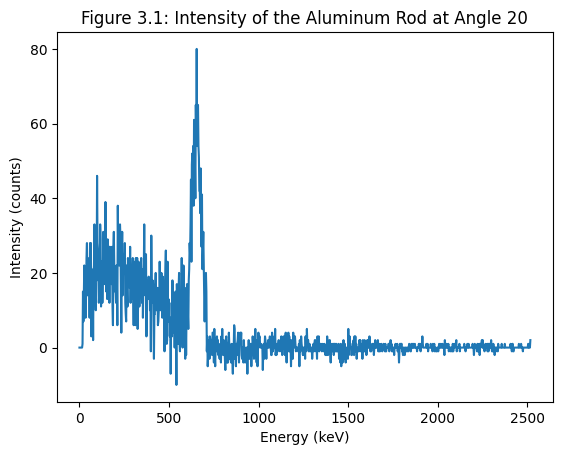

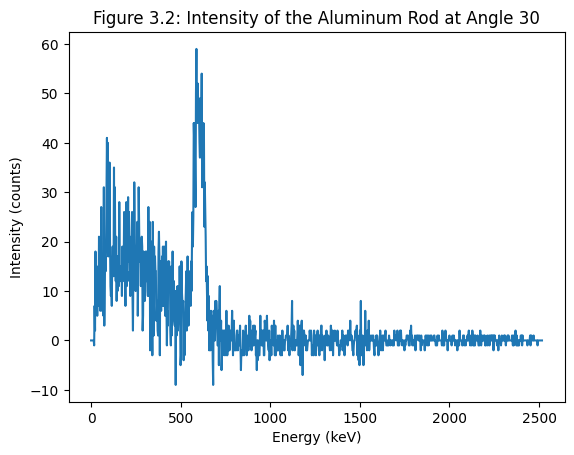

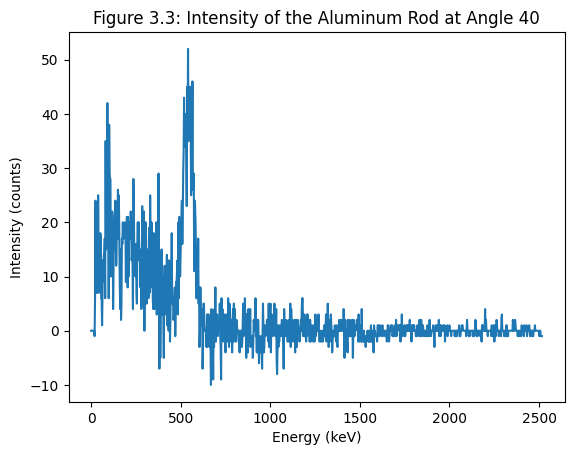

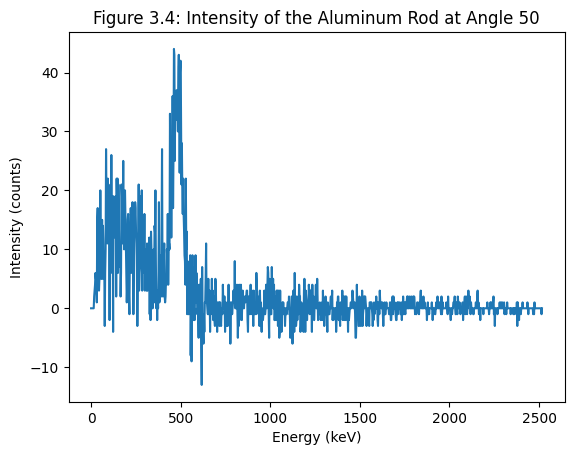

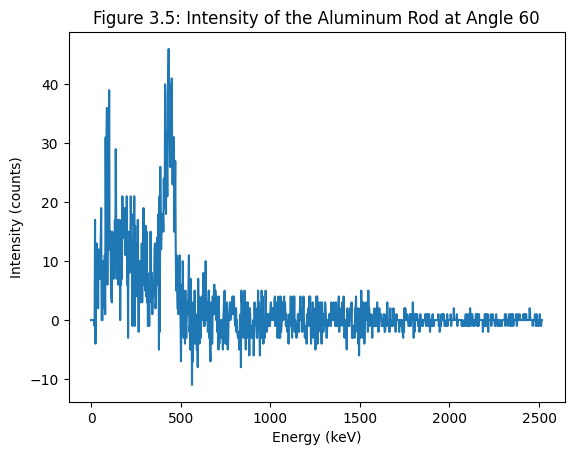

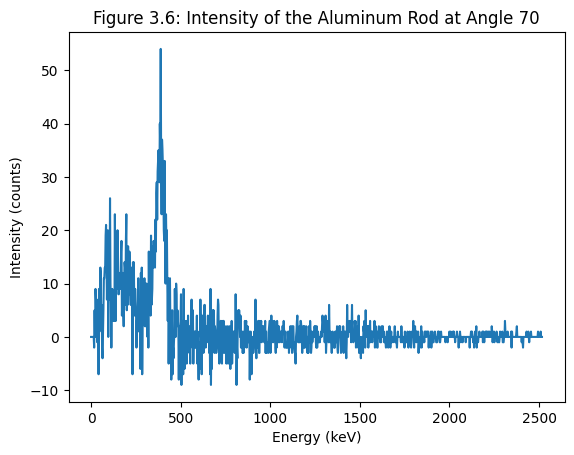

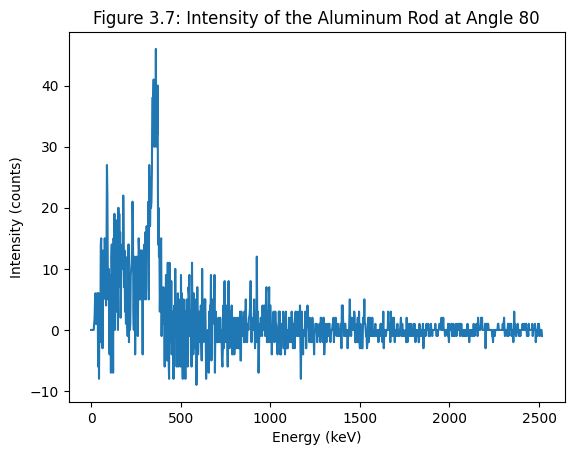

In [15]:
incident_spectrum = importf("S3_NR",1)[0]
channels = [*range(1024)]
energy = np.multiply(channels,conversion_factor)
no_rod_scans = np.zeros((7, 1024))
aluminum_rod_scans = np.zeros((7, 1024))
unknown_rod_scans = np.zeros((7, 1024))
unknown_rod_small_scans = np.zeros((7, 1024))
for x in range(20, 90, 10):
    angle = int(x/10) - 2
    no_rod_scans[angle] = importf("S3_" + str(x) +"_NR",1)[0]
    aluminum_rod_scans[angle] = importf("S3_" + str(x),1)[0]
    unknown_rod_scans[angle] = importf("S3_" + str(x) +"_U",1)[0]
    unknown_rod_small_scans[angle] = importf("S3_" + str(x) + "_US",1)[0]

for x in range (0, 7, 1):
    aluminum_corrected = np.array(aluminum_rod_scans[x])-np.array(no_rod_scans[x])
    plt.plot(energy, aluminum_corrected)
    plt.xlabel("Energy (keV)")
    plt.ylabel("Intensity (counts)")
    plt.title("Figure 3."+str(x+1)+": Intensity of the Aluminum Rod at Angle " + str((x+2)*10))
    plt.show()


2.9185011043486667e+57


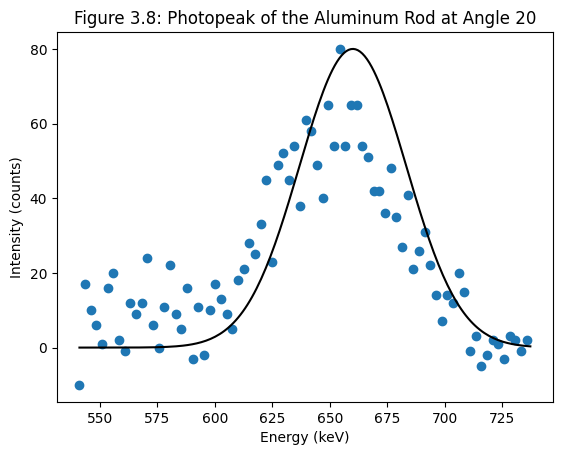

8.046541810011833e+41


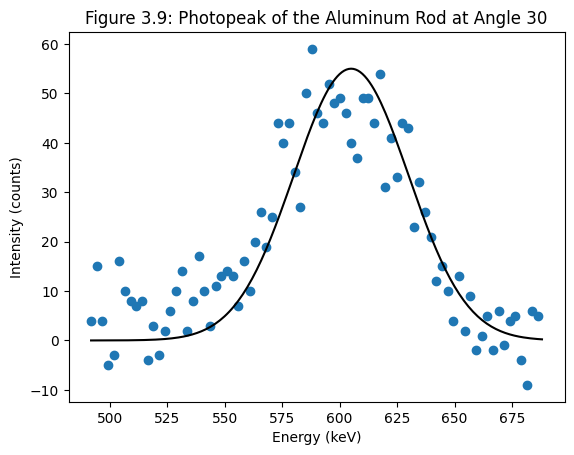

3.4033707813431256e+26


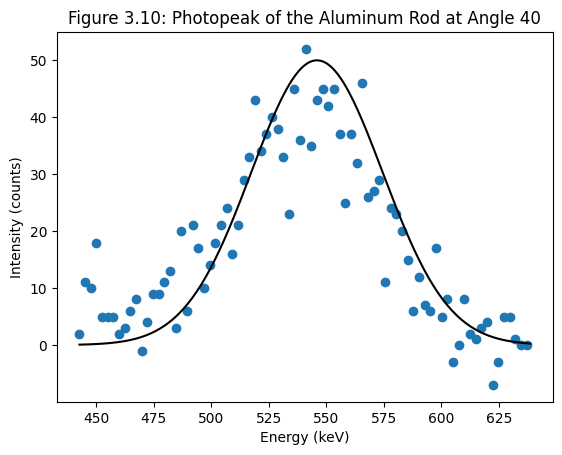

3.167187299736826e+20


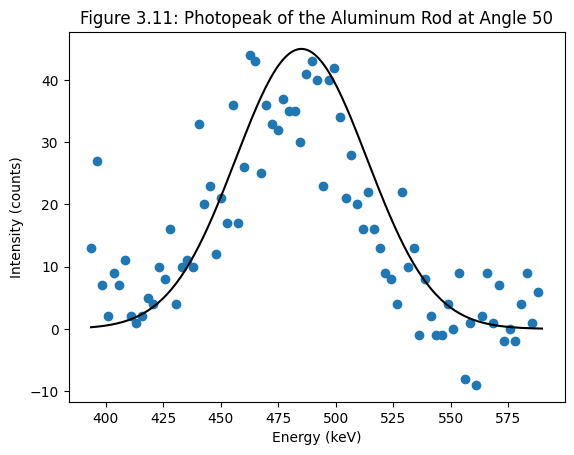

3.820937137242902e+16


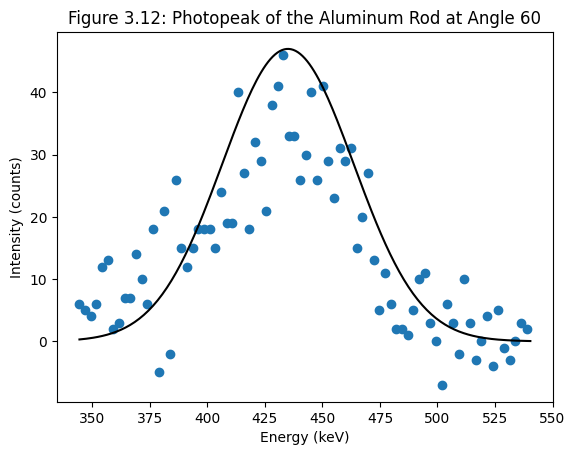

1.8190163613109718e+26


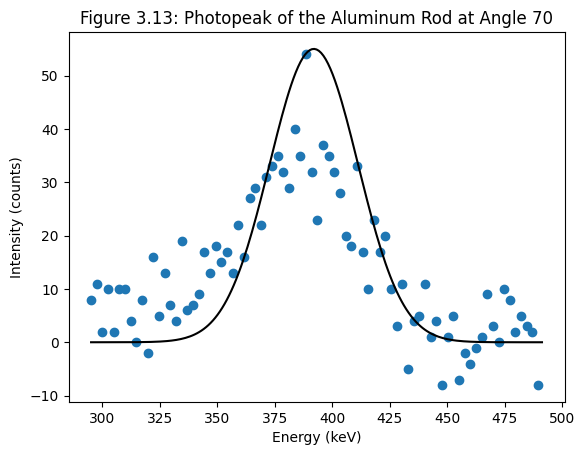

2063898759680906.5


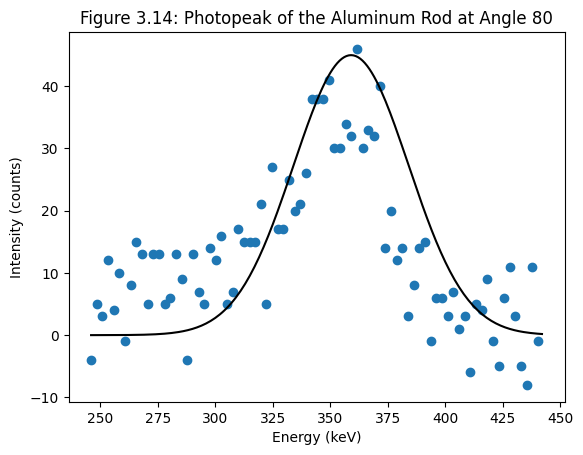

In [16]:
aluminum_peak_values = [80, 55, 50, 45, 47, 55, 45]
aluminum_energy_peaks = [660, 605, 546, 485, 435, 392, 359]
aluminum_last_beta = [0.043, 0.04, 0.035, 0.035, 0.035, 0.052, 0.04]
aluminum_peaks = []
aluminum_peak_error = []
aluminum_tds = []
aluminum_tds_err =[]
for x in range (0, 7, 1):
    aluminum_corrected = np.array(aluminum_rod_scans[x])-np.array(no_rod_scans[x])
    plt.scatter(energy[220-20*x:300-20*x], aluminum_corrected[220-20*x:300-20*x])
    
    max_count = np.max(aluminum_corrected)  # Find the maximum y value
    max_energy = energy[np.argmax(aluminum_corrected)]  # Find the x value corresponding to the maximum y value
    
    min_error = minuteError(220-20*x,300-20*x, energy)
    min_error = np.multiply(min_error,conversion_factor)
    new_params, sd_params, chi_sq = gausPeak(220-20*x,300-20*x,aluminum_corrected, min_error,min_error, 
                                             [aluminum_peak_values[x], aluminum_energy_peaks[x], aluminum_last_beta[x]])
    gaus_fit = gaussian(new_params, np.arange(energy[220-20*x],energy[300-20*x], 1))
    plt.plot(np.arange(energy[220-20*x],energy[300-20*x], 1), gaus_fit, color = 'black')
    aluminum_total_decay, aluminum_total_decay_err = quadrature(gaussian_form,energy[220-20*x],energy[300-20*x], new_params ) 
    aluminum_tds.append(aluminum_total_decay)
    aluminum_tds_err.append(aluminum_total_decay_err)
    
    aluminum_peaks.append(new_params[1])
    aluminum_peak_error.append(sd_params[1])
    print(sd_params[1])
    
    plt.xlabel("Energy (keV)")
    plt.ylabel("Intensity (counts)")
    plt.title("Figure 3."+str(x+8)+": Photopeak of the Aluminum Rod at Angle " + str((x+2)*10))
    plt.show()
    #print(max_count, max_energy)

Figures 3.15-3.21 showcase the varying intensities with the unknown scattering rod in the setup with different angles, while Figures 3.22-3.28 showcase the largest photopeak fitted with a gaussian function for each angle. 

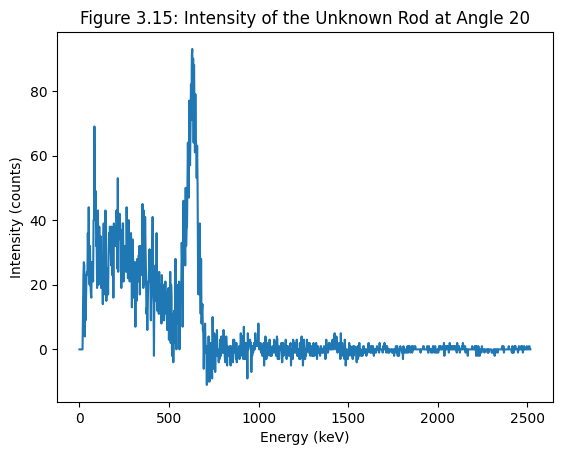

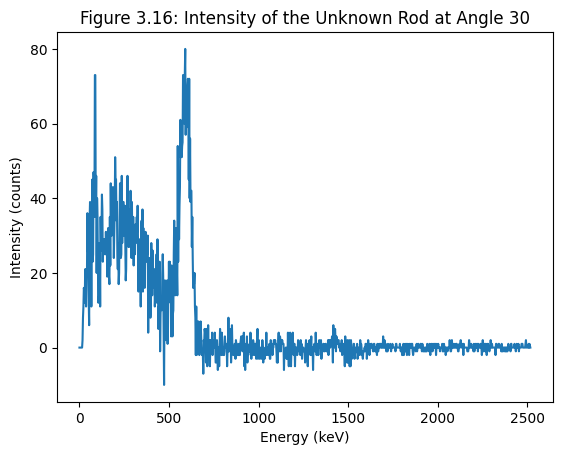

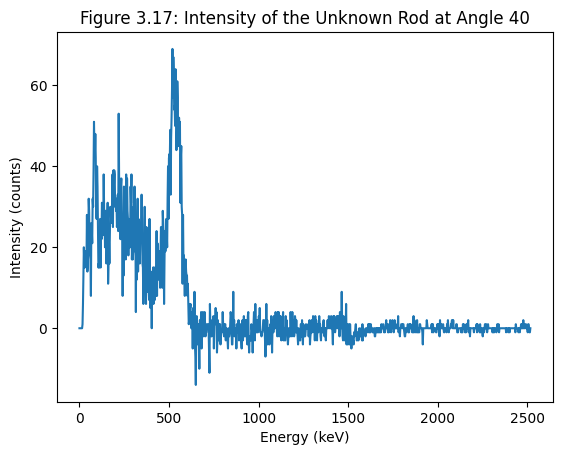

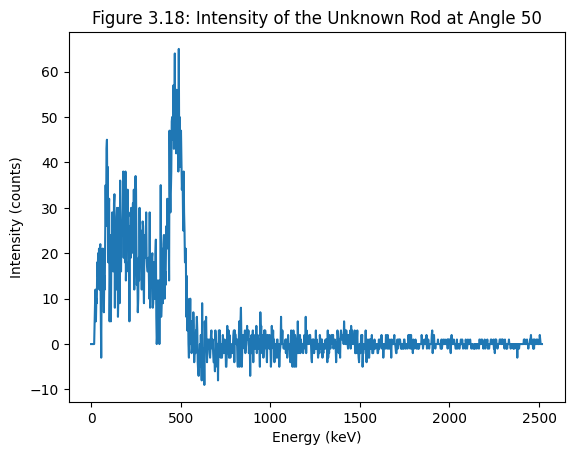

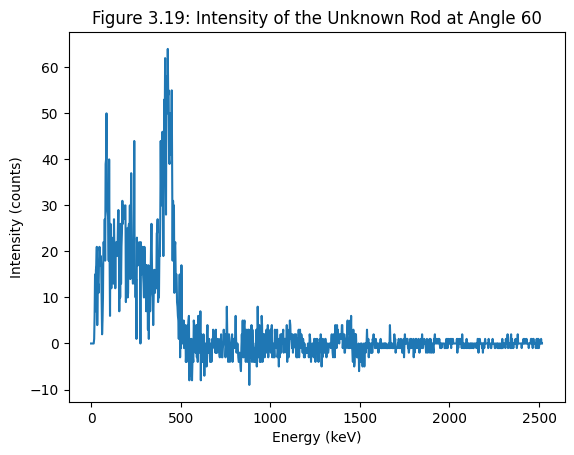

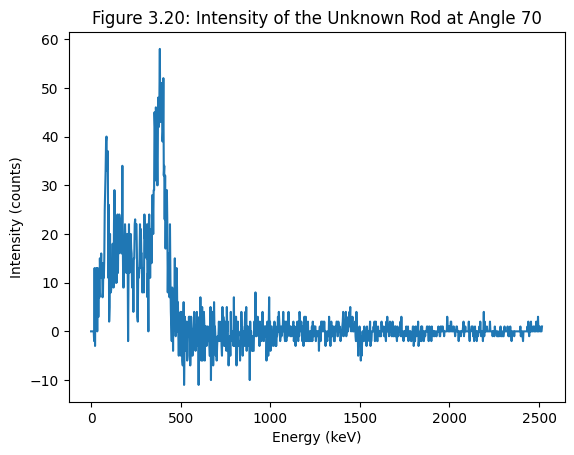

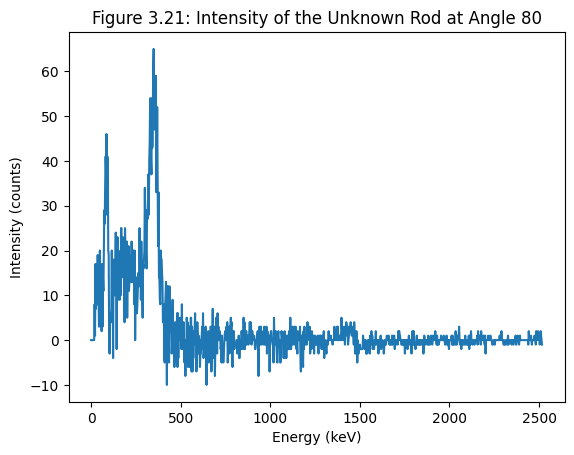

In [17]:
for x in range (0, 7, 1):
    unknown_corrected = np.array(unknown_rod_scans[x])-np.array(no_rod_scans[x])
    plt.plot(energy, unknown_corrected)
    plt.xlabel("Energy (keV)")
    plt.ylabel("Intensity (counts)")
    plt.title("Figure 3."+str(x+15)+": Intensity of the Unknown Rod at Angle " + str((x+2)*10))
    plt.show()

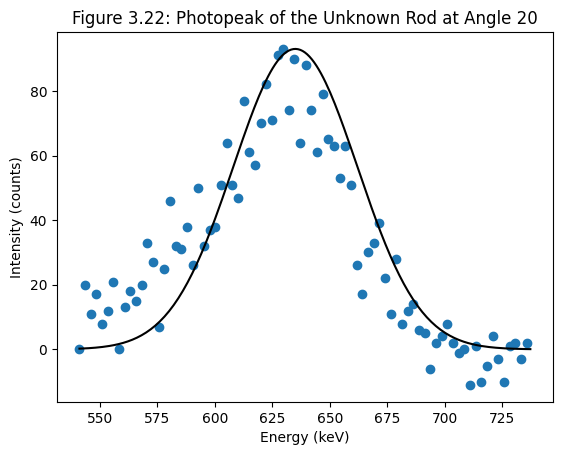

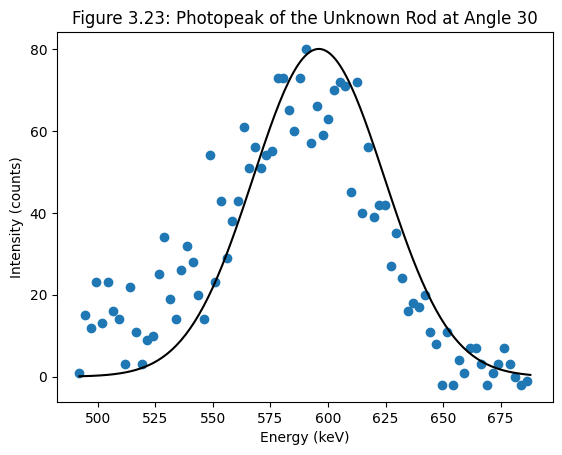

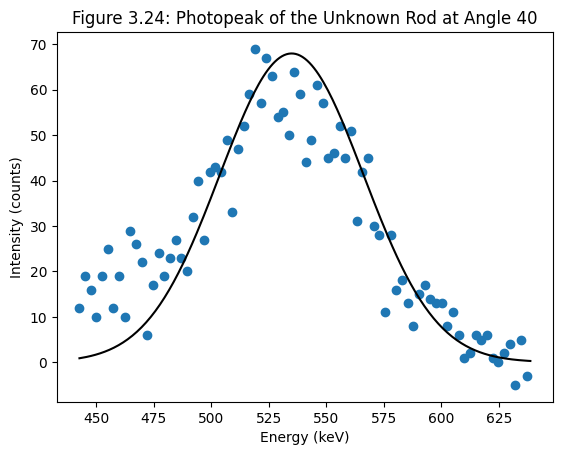

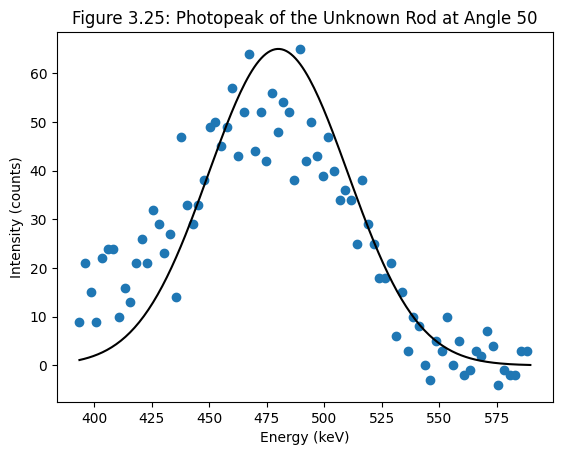

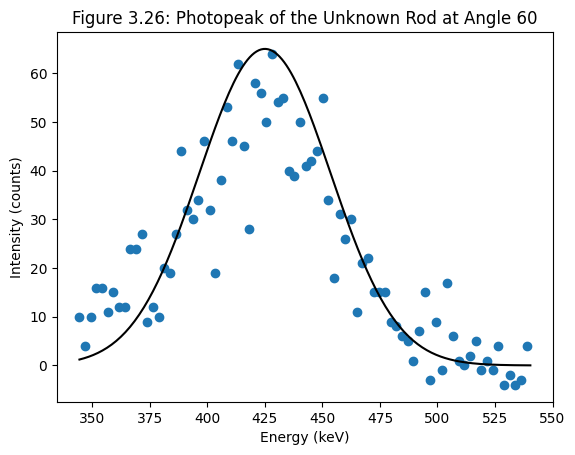

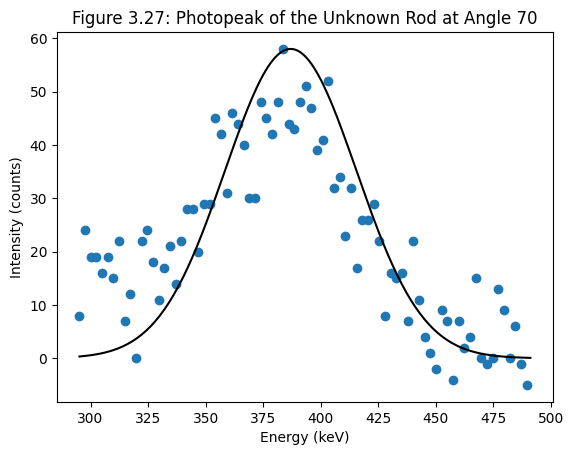

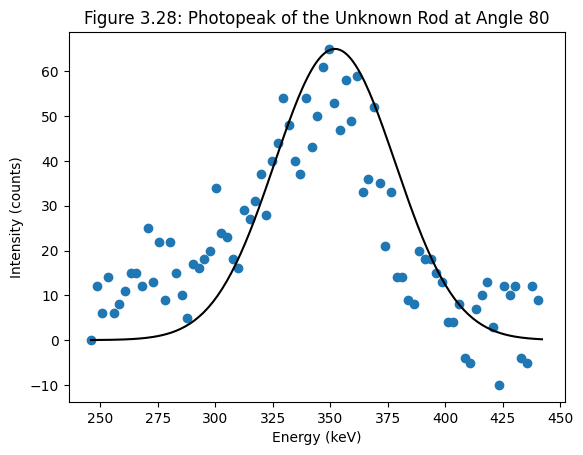

In [18]:
unknown_peak_values = [93, 80, 68, 65, 65, 58, 65]
unknown_energy_peaks = [635, 596, 535, 480, 425, 387, 352]
unknown_last_beta = [0.037, 0.035, 0.032, 0.033, 0.035, 0.035, 0.038]
unknown_peaks = []
unknown_peak_error = []
unknown_tds = []
unknown_tds_err = []
for x in range (0, 7, 1):
    unknown_corrected = np.array(unknown_rod_scans[x])-np.array(no_rod_scans[x])
    plt.scatter(energy[220-20*x:300-20*x], unknown_corrected[220-20*x:300-20*x])
    
    max_count = np.max(unknown_corrected)  # Find the peak value
    max_energy = energy[np.argmax(unknown_corrected)]  # Find the energy value corresponding to the peak value
    
    min_error = minuteError(220-20*x,300-20*x, energy)
    min_error = np.multiply(min_error,conversion_factor)
    new_params, sd_params, chi_sq = gausPeak(220-20*x,300-20*x,unknown_corrected, min_error,min_error, 
                                             [unknown_peak_values[x], unknown_energy_peaks[x], unknown_last_beta[x]])
    gaus_fit = gaussian(new_params, np.arange(energy[220-20*x],energy[300-20*x], 1))
    plt.plot(np.arange(energy[220-20*x],energy[300-20*x], 1), gaus_fit, color = 'black')
    unknown_total_decay, unknown_total_decay_err = quadrature(gaussian_form,energy[220-20*x],energy[300-20*x], new_params ) 
    unknown_tds.append(unknown_total_decay)
    unknown_tds_err.append(unknown_total_decay_err)
    
    
    unknown_peaks.append(new_params[1])
    unknown_peak_error.append(sd_params[1])
    
    plt.xlabel("Energy (keV)")
    plt.ylabel("Intensity (counts)")
    plt.title("Figure 3."+str(x+22)+": Photopeak of the Unknown Rod at Angle " + str((x+2)*10))
    plt.show()
    #print(max_count, max_energy)

After gathering the primary peak energy data for both scattering rods, plot the changing peak energy shown in each photopeak as a function of angle, one plot for aluminum, another for the unknown scattering rod. After using ODR regression fitted using Equation 3.4 (shown again below), setting the unknown parameter to $m$, the mass of an electron, we can experimentally determine a value for $m$.

$$E' = \frac{E}{1+(E/mc^2)(1-cos\theta)}$$
<div style="text-align: right">Equation 3.4</div>

Figure 3.29 shows the incident photons from Cs-137, with the largest primary peak being incident peak energy $E$ used in Equation 3.4 and both regressions for the scattering rods. The primary peaks are used as they lead the behavior of the energy shifts, with the energy downshifts moving some other peaks below 0. 

Figure 3.30 is the plot and regression using the aluminum scattering rod, while Figure 3.31 is the one using the unknown scattering rod.

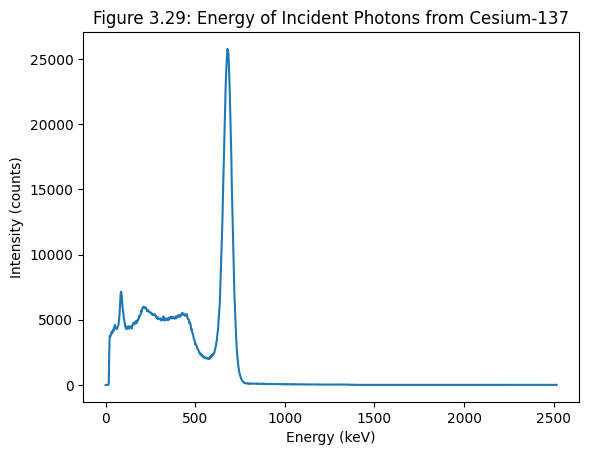

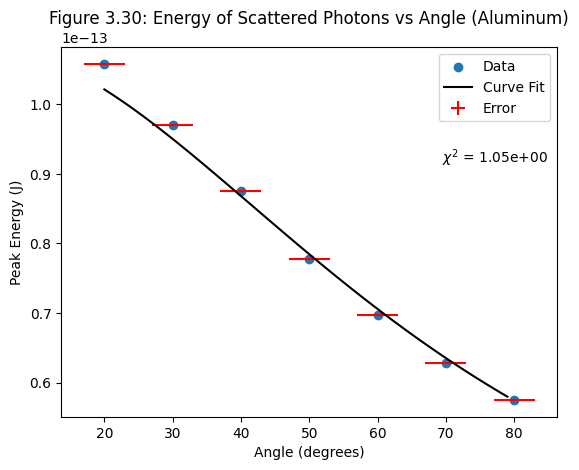

m =  [1.11735377e-30]  ±  [4.25055241e-32]


In [19]:
plt.plot(energy, Ecali_Cs)
plt.title("Figure 3.29: Energy of Incident Photons from Cesium-137")
plt.xlabel("Energy (keV)")
plt.ylabel("Intensity (counts)")
plt.show()

incident_energy_peak = energy[np.argmax(Ecali_Cs)]  # Find the energy value corresponding to the peak value
c_sq = (const.c)**2

angles = [20, 30, 40, 50, 60, 70, 80]
angle_error = 3

def shifting_energy(param, x):
    joules_peak = incident_energy_peak*1.60218*(10**(-16))
    return joules_peak/(1 + (joules_peak/(param*c_sq))*(1 - np.cos(np.deg2rad(x)) ))

aluminum_peaks = np.multiply(aluminum_peaks, 1.60218*(10**(-16)))
aluminum_peak_error = np.ones(7)
aluminum_peak_error = np.multiply(aluminum_peak_error, 1.6*(10**(-17)))

figure9 = plt.figure(9)
plt.scatter(angles, aluminum_peaks, label =  "Data")
energy_model = odr.Model(shifting_energy)
odr_data = odr.RealData(angles, aluminum_peaks, sx = angle_error, sy = aluminum_peak_error)
regressed_model = odr.ODR(odr_data, energy_model, beta0 = [9.1*(10**(-31))])
output = regressed_model.run()
#output.pprint()

new_params = output.beta
sd_params = output.sd_beta
chi_sqr = output.res_var

func_fit = shifting_energy(new_params, np.arange(20, 80,1))
plt.errorbar(angles, aluminum_peaks, xerr = angle_error, yerr = aluminum_peak_error, color = 'red', linestyle = "None",
             label = "Error")
plt.plot(np.arange(20, 80,1), func_fit, color = 'black', label = "Curve Fit")
plt.legend()
plt.title("Figure 3.30: Energy of Scattered Photons vs Angle (Aluminum)")
plt.xlabel("Angle (degrees)")
plt.ylabel("Peak Energy (J)")
figure9.text(0.72,0.64,r'$\chi^2$ = {:.2e}'.format(chi_sqr))
plt.show()
print("m = ", new_params, " ± ", sd_params)

The estimated electron mass using the aluminum peak data is $m = 1.097 * 10^{-30} \pm 0.0307 *10^{-30} kg$. Given the very low $\chi^2$ value of $0.563$, this fit is very good. 

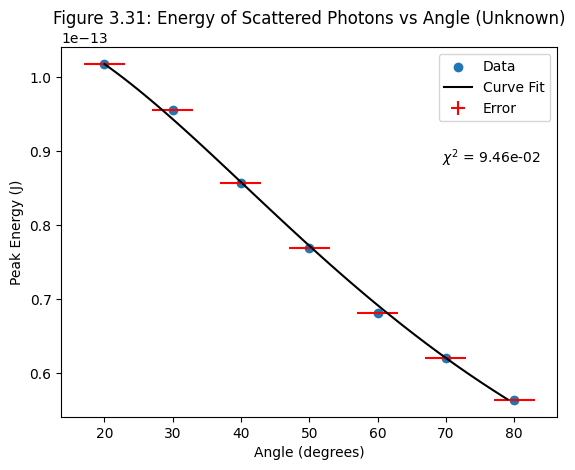

m =  [1.05723108e-30]  ±  [1.21100168e-32]


In [20]:
angles = [20, 30, 40, 50, 60, 70, 80]
angle_error = 3

unknown_peaks = np.multiply(unknown_peaks, 1.60218*(10**(-16)))
unknown_peak_error = np.ones(7)
unknown_peak_error = np.multiply(unknown_peak_error, 1.6*(10**(-17)))

figure10 = plt.figure(10)
plt.scatter(angles, unknown_peaks, label =  "Data")
energy_model = odr.Model(shifting_energy)
odr_data = odr.RealData(angles, unknown_peaks, sx = angle_error, sy = unknown_peak_error)
regressed_model = odr.ODR(odr_data, energy_model, beta0 = [9.1*(10**(-31))])
output = regressed_model.run()
#output.pprint()

new_params = output.beta
sd_params = output.sd_beta
chi_sqr = output.res_var

func_fit = shifting_energy(new_params, np.arange(20, 80,1))
plt.errorbar(angles, unknown_peaks, xerr = angle_error, yerr = unknown_peak_error, color = 'red', linestyle = "None",
             label = "Error")
plt.plot(np.arange(20, 80,1), func_fit, color = 'black', label = "Curve Fit")
plt.legend()
plt.title("Figure 3.31: Energy of Scattered Photons vs Angle (Unknown)")
plt.xlabel("Angle (degrees)")
plt.ylabel("Peak Energy (J)")
figure10.text(0.72,0.64,r'$\chi^2$ = {:.2e}'.format(chi_sqr))
plt.show()
print("m = ", new_params, " ± ", sd_params)

The estimated electron mass using the unknown peak data is $m = 1.038 * 10^{-30} \pm 0.0127 *10^{-30} kg$. Given the extremely low $\chi^2$ value of $0.107$, this fit is extremely good. 

The average estimated electron mass using both sets of data is $m = 1.068 * 10^{-30} \pm 0.0217*10^{-30} kg$. While the actual value of electron mass, $9.109 * 10^{-31} kg$, is outside the standard deviation of the estimated values, it is still within a reasonable range to the estimated values.

## Section 4: Differential Cross-Section of Aluminum Rod and Classical Radius of an Electron


### Error Analysis

Mass Measurements are found using a triple beam balance, having an error of $\pm 0.1 \, g$, or $\pm 0.0001 \, kg$

Displacement and diameter measurements are found by viewing a ruler's metric side, having an error of $\pm 0.1 \, cm$, or $\pm 1 \, mm$

### Measurements

Mass of the Aluminum Rod: $146.5 \pm 0.1 \, g$ <br>
Mass of the Unknown Rod: $479.6 \pm 0.1 \, g$ <br>
Diameter of the Aluminum Rod: $17 \pm 1 \, mm$ <br>
Diameter of the Unknown Rod: $17 \pm 1 \, mm$ <br>
Height of the Aluminum Rod: $186 \pm 1 \, mm$ <br>
Height of the Unknown Rod: $194 \pm 1 \, mm$ <br>
Volume of the Aluminum Rod: $\pi * (8.5 \pm 0.5)^2  *(186 \pm 1) \, mm^3$ <br>
Volume of the Unknown Rod: $\pi * (8.5 \pm 0.5)^2 * (194 \pm 1) \, mm^3$ <br>

Using the principle of Compton Scattering, this section further utilizes the data gathered in Section 3 to determine the classical radius of the electron as well as the unknown material. 

### Classical Radius of the Electron

To find the classical radius of the electron we first relate the total number of decays as a function of scattering angle $\theta$ using the aluminum rod data. This can be accomplished by using Equations 4.1 and 4.3 below. 

Equation 4.1, proposed by Klein and Nishina, relates the differential cross-section $\frac{d\sigma}{d\Omega}$ to scattering angle $\theta$. 

$$\frac{d\sigma}{d\Omega} = \frac{r^2}{2}\biggl[\frac{1 + cos^2\theta}{[1 + \alpha(1-cos\theta)]^2}\biggr]\biggl[1 + \frac{\alpha^2(1-cos\theta)^2}{(1 + cos^2\theta)[1+\alpha(1-cos\theta)]}\biggr]$$
<div style="text-align: right">Equation 4.1</div>

where $\frac{d\sigma}{d\Omega}$ is the differential cross-section for Compton scattering of the aluminum rod, $r$ is the classical radius of the electron, $\theta$ is the scattering angle, and $\alpha$ is the ratio of the unscattered $\gamma$-ray energy to the rest energy of an electron represented by Equation 4.2 below. 

$$\alpha = \frac{E_{\gamma}}{mc^2}$$
<div style="text-align: right">Equation 4.2</div>

where $\alpha$ is the ratio of the unscattered $\gamma$-ray energy to the rest energy of an electron, $E_{\gamma}$ is the unscattered $\gamma$-ray energy, and $mc^2$ is the rest energy of an electron, using $m$ the rest mass determined from the previous section.

Equation 4.3 relates the differential cross-section $\frac{d\sigma}{d\Omega}$ to $\Sigma_{\gamma}$', the total number of decays as a function of $\theta$. 

$$\frac{d\sigma}{d\Omega} = \frac{E_{\gamma}\,'}{n_{\theta}I\Delta\Omega t \epsilon}$$
<div style="text-align: right">Equation 4.3</div>

where $\frac{d\sigma}{d\Omega}$ is the differential cross-section for Compton scattering of the aluminum rod, $E_{\gamma}'$ is the integral of the shifted photopeak (the total number of decays), $n_e$ is the number of electrons in the portion of the scatterer illuminated by the incident gamma rays, $I$ is the number of incident $\gamma$-rays/$cm^2$ per second at the scattering rod, $\Delta\Omega$ is the solid angle of the scintillation detector, $t$ is the length of time of the scan (120 s), and $\epsilon$ is the efficiency of the detector. 

$n_\theta$, which is the number of electrons in the portion of the scatterer illuminated by the incident gamma rays, can be found using Equation 4.4 below:

$$n_\theta = \rho V N_A \sum_i w_i \frac{Z_i}{M_i}$$
<div style="text-align: right">Equation 4.4</div>

where $\rho$ is the density of the scattering rod, $V$ is the scattering volume of the rod, $N_A$ is Avogadro's number, $\sum_i w_i$ is the weight fraction of the scattering rod, $Z_i$ is the atomic number of $i$th material of the rod, and $M_i$ is the molar mass of the $i$th material of the rod. 

The solid angle of the scintillator $\Delta\Omega$ can be calculated using Equation 4.5 below.
$$\Delta\Omega = \frac{\pi (D/2)^2}{R_2\,^2}$$
<div style="text-align: right">Equation 4.5</div>

where $D$ is the diameter of the scintillator, and $R_2$ is the distance from the center of the scattering rod to the front of the detector.

The efficiency of the scintillator $\epsilon$ can be determined after analyzing Figure 4.1 below, which details the efficiency of a photodetector depending on the energy of the radiation as well as the area of the scintillator. 

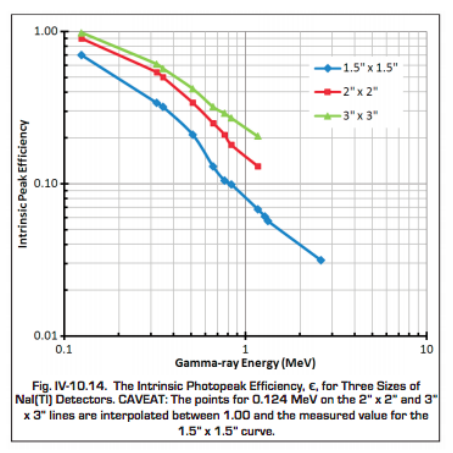
<center>Figure 4.1: Efficiency of the Photodetector</center>

For the particular case of a 2” x 2” scintillator, $\epsilon$ can be found using the Equation 4.6 below, derived from Figure 4.1.

$$\epsilon = -0.5E + 0.58$$
<div style="text-align: right">Equation 4.6</div>

where $E$ is the unscattered $\gamma$-ray energy of the source in MeV.

For the incident $\gamma$-rays/$cm^2$ per second at the scattering rod, $I$, there are 2 methods to obtain compute it.

#### Approach 1:

$I$ can be represented via Equation 4.7 below due to the intrinsic behavior of the Cs-137 source:

$$I = \frac{A_0 f}{4 \pi R_1 \,^2}$$
<div style="text-align: right">Equation 4.7</div>

where $A_0$ is the activity of the source, $f$ is the fraction of gamma-ray emissions, and $R$ is the distance from the source to the center of the scattering rod.

#### Approach 2:

$I$ can be determined by first computing the incident flux at the detector, which can be calculated by dividing the total number of decays in the integral of the photopeak by the area of the detector and the scan time. 

This then can be scaled using the inverse square law to estimate $I$ at the scattering rod. 

In [21]:
E_y = 661.7 * 1.60218*(10**(-16)) #keV to J
m = 1.068 * (10**(-30))

alpha = E_y/(m*c_sq)
def radius_finding(param, x):
    plus_cos_sq = 1+(np.cos(np.deg2rad(x))**2)
    minus_cos = 1-np.cos(np.deg2rad(x))
    right_side = 1 + ((alpha**2)*(minus_cos**2))/(plus_cos_sq*(1 + alpha*minus_cos))
    return ((param**2)/2) * (plus_cos_sq/((1+alpha*minus_cos)**2)) * right_side
#n_theta
mass_alu = 146.5*(10**(-3))
mass_unk = 479.6*(10**(-3))
mass_err = 0.1*(10**(-3))

r_sq, r_sq_err = exponent_err(0.85, 2, 0.05)
pi_r_sq = np.multiply(r_sq, np.pi)
pi_r_sq_err = np.multiply(r_sq_err, np.pi)
height_alu = 186 * 0.1
height_unk = 194 * 0.1
height_err = 1 * 0.1

molar_alu = 26.98
alu_atomic = 13
alu_percent = 98.6 * 0.01

molar_mg = 24.305
mg_atomic = 12
mg_percent = 0.8 * 0.01

molar_si = 28.084
si_atomic = 14
si_percent = 0.4 * 0.01

molar_fe = 55.845
fe_atomic = 26
fe_percent = 0 * 0.01

molar_cu = 63.546
cu_atomic = 29 
cu_percent = 0.15 * 0.01

molar_cr = 51.996
cr_atomic = 24
cr_percent = 0.05 * 0.01

molar_zn = 65.38
zn_atomic = 30
zn_percent = 0 * 0.01

molar_mn = 54.938
mn_atomic = 25
mn_percent = 0 * 0.01

molar_ti = 47.867
ti_atomic = 22
ti_percent = 0 * 0.01

percent_check = alu_percent + mg_percent + si_percent + fe_percent + cu_percent + zn_percent
+ cr_percent + mn_percent + ti_percent

weight_fraction = (alu_percent*alu_atomic/molar_alu) + (mg_percent*mg_atomic/molar_mg) + (si_percent*si_atomic/molar_si) 
+ (fe_percent*fe_atomic/molar_fe) + (cu_percent*cu_atomic/molar_cu) + (cr_percent*cr_atomic/molar_cr) + (zn_percent*zn_atomic/molar_zn) 
+ (mn_percent*mn_atomic/molar_mn) + (ti_percent*ti_atomic/molar_ti)
scattering_vol, scattering_vol_err = stat_err(pi_r_sq, 2, pi_r_sq_err, 0.01) 
vol_alu, vol_alu_err = stat_err(pi_r_sq, height_alu, pi_r_sq_err, height_err)
vol_unk, vol_unk_err = stat_err(pi_r_sq, height_unk, pi_r_sq_err, height_err)

density_alu, density_alu_err = stat_err(mass_alu, 1/vol_alu, mass_err, vol_alu_err)
density_unk, density_unk_err = stat_err(mass_unk, 1/vol_alu, mass_err, vol_unk_err)

den_vol, den_vol_err = stat_err(density_alu, scattering_vol, density_alu_err, scattering_vol_err)
n_theta = np.multiply(den_vol, const.N_A*weight_fraction)
n_theta_err = np.multiply(den_vol_err, const.N_A*weight_fraction)

Figures 4.2 and 4.3 below detail the incident energy of Cs-137 and the largest photopeak of the energy respectively.

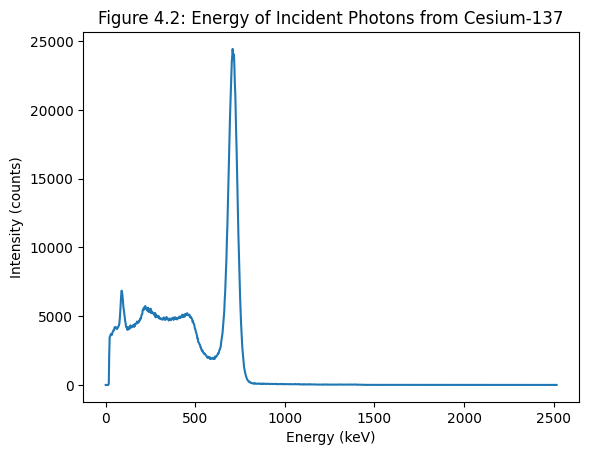

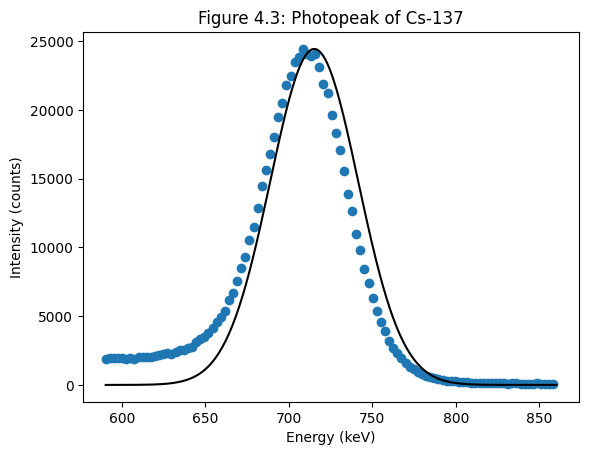

In [22]:
#### Approach 1
A_0 = 10*(10**-3) * 3.7 *(10**10)
f = 0.851
R_1 = 30.5

photon_flux_1 = (A_0*f)/(4*np.pi*(R_1**2)) 

#Approach 2
plt.plot(energy, incident_spectrum)
plt.title("Figure 4.2: Energy of Incident Photons from Cesium-137")
plt.xlabel("Energy (keV)")
plt.ylabel("Intensity (counts)")
plt.show()

#240, 350
plt.scatter(energy[240:350], incident_spectrum[240:350])
min_error = minuteError(240,350, energy)
min_error = np.multiply(min_error,conversion_factor)
new_params, sd_params, chi_sq = gausPeak(240,350, incident_spectrum, min_error,min_error, 
                                            [24436, 715.208, 0.038])
gaus_fit = gaussian(new_params, np.arange(energy[240],energy[350], 1))
plt.plot(np.arange(energy[240],energy[350], 1), gaus_fit, color = 'black')

plt.xlabel("Energy (keV)")
plt.ylabel("Intensity (counts)")
plt.title("Figure 4.3: Photopeak of Cs-137")
plt.show()

incident_count, incident_count_err = quadrature(gaussian_form,energy[240],energy[350], new_params) 
area_detector = np.pi*(5.08/2)**2

photon_flux_detector = incident_count/(area_detector*120)
source_to_detector = 61.0 #cm
source_to_scatter = 30.5 #cm

coefficient = photon_flux_detector*((source_to_detector)**2)
photon_flux_2 = coefficient/(source_to_scatter**2)
#print(photon_flux_2)
#print(photon_flux_1)

After solving for the differential cross-section  $\frac{d\sigma}{d\Omega}$ using Equation 4.3 and the respective necessary following equations, we can then relate and plot $\frac{d\sigma}{d\Omega}$ as a function of scattering angle $\theta$ using Equation 4.1. This then can be fitted using ODR regression, allowing us to experimentally determine the classical electron radius $r$. 

Figures 4.4 and 4.5 below detail these plots for Approach 1 and 2 respectively in determining $I$ while calculating the differential cross-section.

Beta: [3.27101368e-15]
Beta Std Error: [2.68421173e-16]
Beta Covariance: [[2.53025043e-33]]
Residual Variance: 28.47541303356879
Inverse Condition #: 1.0
Reason(s) for Halting:
  Parameter convergence


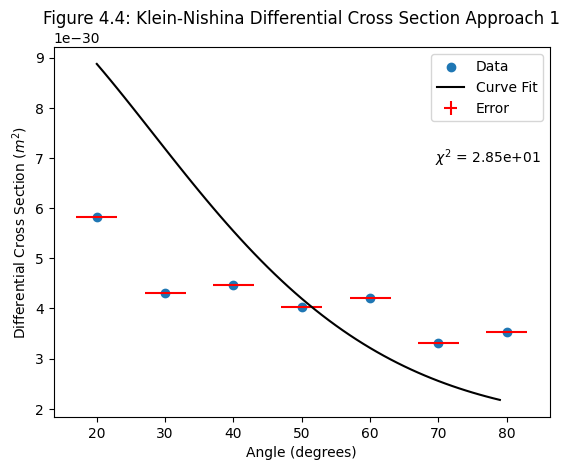

r =  [3.27101368e-15]  ±  [2.68421173e-16] m


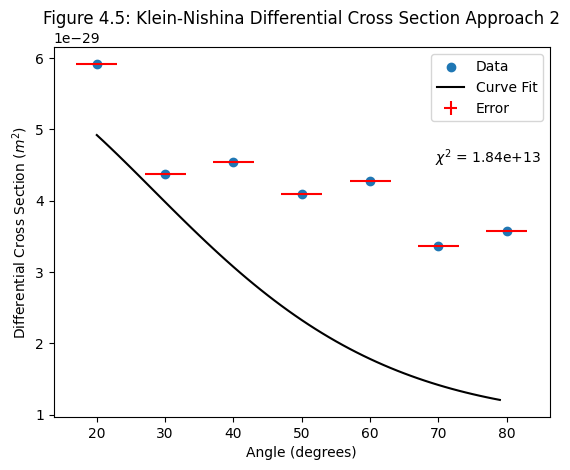

r =  [7.70087124e-15]  ±  [1.08309462e-10] m


In [23]:
solid_angle = (np.pi*(5.08/2)**2)/((30.5)**2)

e_scint = (-0.50 * 0.6617 + 0.58)*(10**(3))
n_I1_omega_t_e = n_theta*photon_flux_1*solid_angle*120*e_scint
n_I2_omega_t_e = n_theta*photon_flux_2*solid_angle*120*e_scint

#change from cm2 to m2
diff_cross_1  = np.multiply(aluminum_tds, 0.01*0.01*1/n_I1_omega_t_e) 
diff_cross_1_err = np.multiply(aluminum_tds_err, 0.01*0.01*1/n_I1_omega_t_e)
diff_cross_2  = np.multiply(aluminum_tds, 0.01*0.01*1/n_I2_omega_t_e) 
diff_cross_2_err = np.multiply(aluminum_tds_err, 0.01*0.01*1/n_I2_omega_t_e)

figure11 = plt.figure(11)
plt.scatter(angles, diff_cross_1, label =  "Data")
scatter_model = odr.Model(radius_finding)
odr_data = odr.RealData(angles, diff_cross_1, sx = angle_error, sy = diff_cross_1_err)
regressed_model = odr.ODR(odr_data, scatter_model, beta0 = [2.817* (10**(-15))])
output = regressed_model.run()
output.pprint()

new_params = output.beta
sd_params = output.sd_beta
chi_sqr = output.res_var

func_fit = radius_finding(new_params, np.arange(20, 80,1))
plt.errorbar(angles, diff_cross_1, xerr = angle_error, yerr = diff_cross_1_err, color = 'red', linestyle = "None",
             label = "Error")
plt.plot(np.arange(20, 80,1), func_fit, color = 'black', label = "Curve Fit")
plt.legend()
plt.title("Figure 4.4: Klein-Nishina Differential Cross Section Approach 1")
plt.xlabel("Angle (degrees)")
plt.ylabel("Differential Cross Section ($m^2$)")
figure11.text(0.72,0.64,r'$\chi^2$ = {:.2e}'.format(chi_sqr))
plt.show()
print("r = ", new_params, " ± ", sd_params, "m")

figure12 = plt.figure(12)
plt.scatter(angles, diff_cross_2, label =  "Data")
scatter_model = odr.Model(radius_finding)
odr_data = odr.RealData(angles, diff_cross_2, sx = angle_error, sy = diff_cross_2_err)
regressed_model = odr.ODR(odr_data, scatter_model, beta0 = [2.817* (10**(-15))])
output = regressed_model.run()

new_params = output.beta
sd_params = output.sd_beta
chi_sqr = output.res_var

func_fit = radius_finding(new_params, np.arange(20, 80,1))
plt.errorbar(angles, diff_cross_2, xerr = angle_error, yerr = diff_cross_2_err, color = 'red', linestyle = "None",
             label = "Error")
plt.plot(np.arange(20, 80,1), func_fit, color = 'black', label = "Curve Fit")
plt.legend()
plt.title("Figure 4.5: Klein-Nishina Differential Cross Section Approach 2")
plt.xlabel("Angle (degrees)")
plt.ylabel("Differential Cross Section ($m^2$)")
figure12.text(0.72,0.64,r'$\chi^2$ = {:.2e}'.format(chi_sqr))
plt.show()
print("r = ", new_params, " ± ", sd_params, "m")

The electron radius estimated through regression and Approach 1 for the photon flux is $3.27 * 10^{-15} \pm 2.68* 10^{-16} \, m$. The $\chi^2$ value is somewhat large at $28.5$, showing an okay fit to the data.

The electron radius estimated through regression and Approach 2 for the photon flux is $8.14 * 10^{-15} \pm 1.83* 10^{-15} \, m$. The $\chi^2$ value is large at $321$, so the fit is not the most accurate to the data. 

The average estimated electron radius is therefore $8.78 * 10^{-15} \pm 1.57* 10^{-15} m$. The standard deviation of all the estimated radii do not encompass the actual value of the electron radius, that being $2.82 * 10^{-15} \, m$. However, since the estimated radii are all still in the correct order of magnitude, that being $10^{-15} \, m$, the errors in calculation likely comes from small measurement errors made for mass, volume, and angle, as well as the weight fraction entered.

### Composition Determination

The final part of this experiment focuses on determining the composition of the unknown material. The differential cross-section $\frac{d\sigma}{d\Omega}$ is identical for the unknown material, and total decays $\Sigma_{\gamma}$' as a function of scattering angle. 

This relation is established using Equation 4.3, and can used to determine the unknown material's number of electrons in the scatterer illuminated by the incident gamma rays $n_\theta$ using regression. This can then be used with Equation 4.4 to help determine the ratio of atomic number to molar mass $\frac{Z_i}{M_i}$, which can be matched to determine the unknown material.

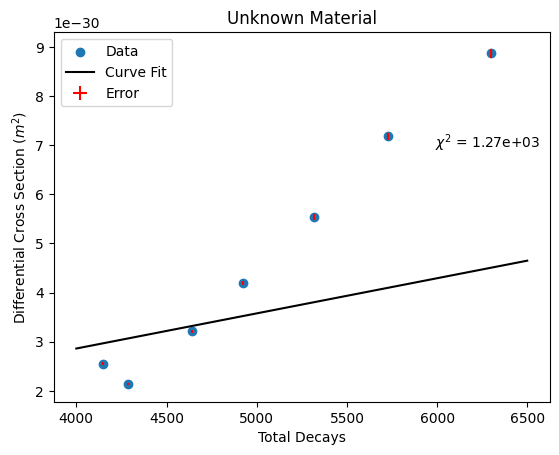

n_theta =  [7.96771582e+25]  ±  [1.13863243e+25]
ratio of unknown Z/M:  [264.49348159]  ±  [18.90743632]
ratio of Copper Z/M: [ 456.36232020898245 ]


In [24]:
def material_class(param, x):
    bottom = photon_flux_1*param*solid_angle*e_scint*120
    return x/bottom

estimated_radius = 3.27 * (10**(-15))
unk_cross_sections = []
unk_cross_sections_err = []
for x in range(20, 90, 10):
    temp = radius_finding(3.27 * (10**(-15)), x)
    unk_cross_sections.append(temp)
    unk_cross_sections_err.append(temp*0.01)


figure13 = plt.figure(13)
plt.scatter(unknown_tds, unk_cross_sections, label =  "Data")
material_model = odr.Model(material_class)
odr_data = odr.RealData(unknown_tds, unk_cross_sections, sx = unknown_tds_err, sy = unk_cross_sections_err)
regressed_model = odr.ODR(odr_data, material_model, beta0 = [density_unk*vol_unk*const.N_A*cu_atomic/(molar_cu*10**(-3))])
output = regressed_model.run()

new_params = output.beta
sd_params = output.sd_beta
chi_sqr = output.res_var

func_fit = material_class(new_params, np.arange(4000, 6500,1))
plt.errorbar(unknown_tds, unk_cross_sections, xerr = unknown_tds_err, yerr = unk_cross_sections_err, color = 'red', linestyle = "None",
             label = "Error")
plt.plot(np.arange(4000, 6500,1), func_fit, color = 'black', label = "Curve Fit")
plt.legend()
plt.title("Unknown Material")
plt.xlabel("Total Decays")
plt.ylabel("Differential Cross Section ($m^2$)")
figure13.text(0.72,0.64,r'$\chi^2$ = {:.2e}'.format(chi_sqr))
plt.show()
print("n_theta = ", new_params, " ± ", sd_params)
ratio = new_params/(const.N_A * density_unk * vol_unk)
ratio_err = sd_params/const.N_A
print("ratio of unknown Z/M: ", ratio, " ± ", ratio_err)
print("ratio of Copper Z/M: [", cu_atomic/(molar_cu*10**(-3)),"]")

$n_\theta$ is approximately $7.97 * 10^25 \pm 1.14*10^25$ particles for the unknown rod. This has a $\chi^2$ value of $1270$, so the fit is not very good. This can potentially be explained by the beta0 value entered, which was assuming a pure material copper scattering rod, which most likely isn't the case, as well as human measurement errors in measuring things such as mass, weight, and height. 

The estimated ratio of $\frac{Z}{M}$ determined for the unknown material was $264.42 \pm 18.91$. The ratio of Cu's $\frac{Z}{M}$ is $456.36$ for comparison, and is not in the standard deviation of the unknown material. It is, however, in the right order of magnitude. This can be explained again by both an error in assuming a pure material scattering rod, as well as human measurement error. 

# Conclusion

In conclusion, in the process of completing the lab, the effects of Compton Scattering and gamma-ray propogation were tested and verified. The inverse-square law relationship of intensity was confirmed, as well as the effects and process of attenuation. Through determining the classical mass and radius of an electron, as well as an unknown scattering rod's material, the properties of Compton scattering were also clearly displayed. 

There were no real major issues with each section, with the only major error being from section two, in which the predicted mass attentuation value was calculated to be around 2 orders of magnitude greater than that of the experimentally determined one. The experimentally determined one had an extremely good fit to the data, so it is likely that there might be some unknown variable not taken into account in the calculation that would reduce said order of magnitude to match that of the experimentally determined one.

Besides this error, the later sections testing Compton scattering directly yielded predicted values outside the standard deviation of the experimental, despite being in the correct order of magnitude. Given how this occured in every one, it is likely this is a human error of calculating/setting up error propogation as well as human measurement error. 

Otherwise, the goals of the lab were achieved. The calibration and energy fits worked perfectly, and the photopeaks were documented. Section 1 demonstrated intensity having an inverse square relationship with distance, Section 2 demonstrated the attenuating effects of metal, and Section 3 yielded a really close experimental value of electron mass, thereby demonstrating the properties of Compton Scattering. Section 4 yielded a reasonable experimental value of electron radius.

The main goals of this lab were hence achieved, with the most standout errors being human error that consistently would lead to just barely having the predicted/accepted values within the standard deviation of the experimental.  The principles of the underlying physics are hence prominently demonstrated within this lab.